# CNN Aiming for Higher Performance - With Nudging!

Maybe with some interpretability now?

We want to nudge the output of our first conv layer to something that makes sense!

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

### Intermediate Data Labels

In [4]:
train_horizontal_image_labels = load_intermediate_labels("train_horizontal_image_labels.pkl")
val_horizontal_image_labels = load_intermediate_labels("val_horizontal_image_labels.pkl")
test_horizontal_image_labels = load_intermediate_labels("test_horizontal_image_labels.pkl")

In [5]:
train_vertical_image_labels = load_intermediate_labels("train_vertical_image_labels.pkl")
val_vertical_image_labels = load_intermediate_labels("val_vertical_image_labels.pkl")
test_vertical_image_labels = load_intermediate_labels("test_vertical_image_labels.pkl")

## CNN Architecture

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 8 interpretable filters - 4 for h edges, 4 for vertical edges
        self.conv1_interpretable = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.conv2_interpretable = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        
        self.conv1_free = nn.Conv2d(1, 24, kernel_size=3, padding=1)          # 24 free filters
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32,   
                  out_channels=64,                
                  kernel_size=3,                 
                  stride=1,                      
                  padding=1)                     
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        # convolutional layer 1
        interp_out1 = self.conv1_interpretable(x)
        interp_out2 = self.conv2_interpretable(x)
        free_out = self.conv1_free(x)
        
        interp_act1 = self.activation_function(interp_out1)
        interp_act2 = self.activation_function(interp_out2)
        free_act = self.activation_function(free_out)

        conv_act = torch.cat((interp_act1, interp_act2, free_act), dim=1)
        
        # pooling layer 1
        pool_out = self.pool1(conv_act)

        # convolutional layer 2
        conv_out2 = self.conv2(pool_out)
        conv_act2 = self.activation_function(conv_out2)

        # pooling layer 2
        pool_out2 = self.pool2(conv_act2)

        # hidden layer
        fc1_in = pool_out2.view(pool_out2.size(0), -1)
        fc1_out = self.fc1(fc1_in)
        fc1_act = self.activation_function(fc1_out)

        # classification
        classification_out = self.fc2(fc1_act)
        
        return classification_out, interp_act1, interp_act2, conv_act

In [7]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
model = CNN().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()

def interp_loss_fn(activations, target_maps):
    """
    So that each filter in the group learns the same feature type, but is independent in how they do so
    
    activations: Shape [batch_size, 4, 28, 28] - 4 feature maps from interpretable filters
    target_maps: Shape [batch_size, 1, 28, 28] - Binary maps of horizontal/vertical edges
    """
    batch_size = activations.size(0)
    reshaped_targets = target_maps.reshape(batch_size, 1, 28, 28)
    
    # Expand target maps to match activations shape
    expanded_targets = reshaped_targets.expand(-1, 4, -1, -1)
    
    # MSE loss between each filter's activation and the target map
    loss_fn = nn.MSELoss()
    loss = loss_fn(activations, expanded_targets)
    
    return loss

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [9]:
print(f"Model weights (to compare below): {model.conv1_interpretable.weight[0].detach().cpu().numpy()}")

Model weights (to compare below): [[[ 0.2548462   0.27666932 -0.07809083]
  [ 0.30620378 -0.07303452  0.06726357]
  [-0.16228501  0.19576089  0.29384765]]]


What we should see from the above weight matrix output, to verify reproducibility:

```
Model weights (to compare below): [[[ 0.2548462   0.27666932 -0.07809083]
  [ 0.30620378 -0.07303452  0.06726357]
  [-0.16228501  0.19576089  0.29384765]]]
```

## Dataloader

In [10]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).unsqueeze(0).float()
        
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)
        horizontal_edge = torch.from_numpy(self.horizontal_edges[idx].copy()).unsqueeze(0).float()
        vertical_edge = torch.from_numpy(self.vertical_edges[idx].copy()).unsqueeze(0).float()

        return image, label, horizontal_edge, vertical_edge

In [11]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [12]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [13]:
num_epochs = 20
best_val_loss = float('inf')
loss_factor = 0
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, interp_act1, interp_act2, conv_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # interpretable convolution loss functions:
        interp1_loss = interp_loss_fn(interp_act1, horizontal_labels)
        interp2_loss = interp_loss_fn(interp_act2, vertical_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = classification_loss + interp1_loss + interp2_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Epoch 1/20
  Train Loss: 4757.5169
  Val Loss: 0.0788 | Val Acc: 97.50%


Epoch 2/20
  Train Loss: 4149.7000
  Val Loss: 0.0707 | Val Acc: 97.84%


Epoch 3/20
  Train Loss: 4122.4896
  Val Loss: 0.0654 | Val Acc: 98.17%


Epoch 4/20
  Train Loss: 4111.3223
  Val Loss: 0.0572 | Val Acc: 98.35%


Epoch 5/20
  Train Loss: 4103.9784
  Val Loss: 0.0598 | Val Acc: 98.21%


Epoch 6/20
  Train Loss: 4097.9640
  Val Loss: 0.0794 | Val Acc: 98.15%


Epoch 7/20
  Train Loss: 4092.4680
  Val Loss: 0.0999 | Val Acc: 98.03%


Epoch 8/20
  Train Loss: 4088.3594
  Val Loss: 0.1102 | Val Acc: 97.84%


Epoch 9/20
  Train Loss: 4085.9528
  Val Loss: 0.1148 | Val Acc: 97.92%


Epoch 10/20
  Train Loss: 4084.8500
  Val Loss: 0.1483 | Val Acc: 97.41%


Epoch 11/20
  Train Loss: 4083.7396
  Val Loss: 0.0975 | Val Acc: 98.13%


Epoch 12/20
  Train Loss: 4083.3101
  Val Loss: 0.0975 | Val Acc: 98.27%


Epoch 13/20
  Train Loss: 4083.3452
  Val Loss: 0.1319 | Val Acc: 97.92%


Epoch 14/20
  Train Loss: 4083.6861
  Val Loss: 0.1239 | Val Acc: 98.43%


Epoch 15/20
  Train Loss: 4083.3633
  Val Loss: 0.1348 | Val Acc: 98.40%


Epoch 16/20
  Train Loss: 4082.8051
  Val Loss: 0.1187 | Val Acc: 98.12%


Epoch 17/20
  Train Loss: 4083.1635
  Val Loss: 0.1440 | Val Acc: 98.46%


Epoch 18/20
  Train Loss: 4083.2601
  Val Loss: 0.1825 | Val Acc: 98.02%


Epoch 19/20
  Train Loss: 4083.1846
  Val Loss: 0.2007 | Val Acc: 97.82%


Epoch 20/20
  Train Loss: 4083.2070
  Val Loss: 0.1987 | Val Acc: 98.09%


## Evaluation

In [14]:
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 327.37it/s]

Final Test Accuracy: 98.25%


# Explore the CNN

## Weight Layers

Horizontal Convolutions:


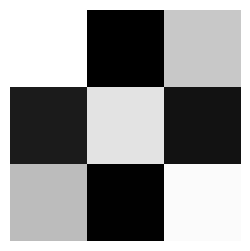

tensor([[[ 0.2656,  0.0040,  0.2093],
         [-0.0324, -0.2377, -0.0224],
         [ 0.1971,  0.0058,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


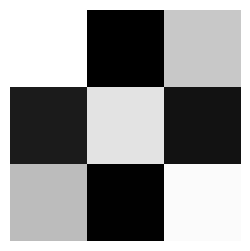

tensor([[[ 0.2656,  0.0040,  0.2093],
         [-0.0324, -0.2377, -0.0224],
         [ 0.1971,  0.0058,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


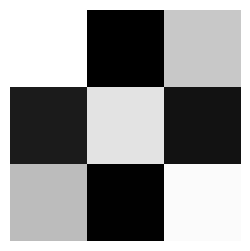

tensor([[[ 0.2656,  0.0040,  0.2093],
         [-0.0324, -0.2377, -0.0224],
         [ 0.1971,  0.0058,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


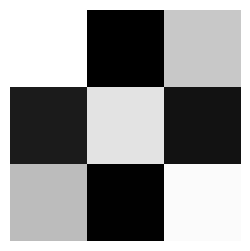

tensor([[[ 0.2656,  0.0040,  0.2093],
         [-0.0324, -0.2377, -0.0224],
         [ 0.1971,  0.0058,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [15]:
print("Horizontal Convolutions:")
for weight in model.conv1_interpretable.weight:
    kernel = np.abs(weight.reshape(3, 3).detach().cpu().numpy())
    
    plt.figure(figsize=(3, 3))
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')
    plt.show()
    print(weight)

Vertical Convolutions:


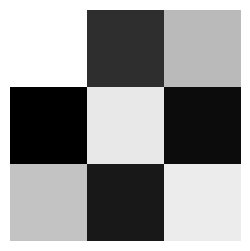

tensor([[[ 0.2794, -0.0821,  0.2138],
         [ 0.0378, -0.2572,  0.0494],
         [ 0.2229, -0.0609,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


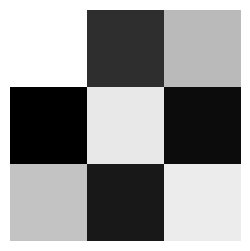

tensor([[[ 0.2794, -0.0821,  0.2138],
         [ 0.0378, -0.2572,  0.0494],
         [ 0.2229, -0.0609,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


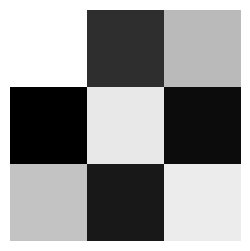

tensor([[[ 0.2794, -0.0821,  0.2138],
         [ 0.0378, -0.2572,  0.0494],
         [ 0.2229, -0.0609,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


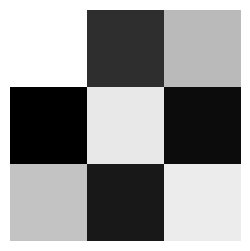

tensor([[[ 0.2794, -0.0821,  0.2138],
         [ 0.0378, -0.2572,  0.0494],
         [ 0.2229, -0.0609,  0.2609]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [16]:
print("Vertical Convolutions:")
for weight in model.conv2_interpretable.weight:
    kernel = np.abs(weight.reshape(3, 3).detach().cpu().numpy())
    
    plt.figure(figsize=(3, 3))
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')
    plt.show()
    print(weight)

Free weights layer one:


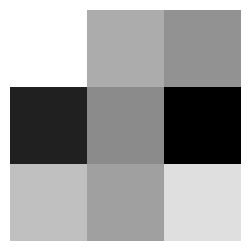

tensor([[[-0.4020, -0.2720,  0.2319],
         [ 0.0546,  0.2215,  0.0049],
         [ 0.3040, -0.2541, -0.3513]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


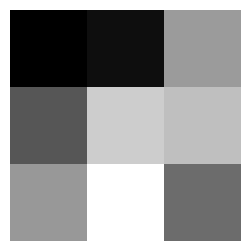

tensor([[[ 0.0057,  0.0261, -0.2201],
         [ 0.1249,  0.2886, -0.2697],
         [-0.2158,  0.3590, -0.1557]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


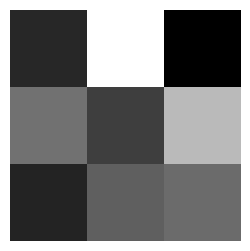

tensor([[[-0.1338, -0.4751, -0.0719],
         [ 0.2505,  0.1699, -0.3654],
         [ 0.1284, -0.2227, -0.2404]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


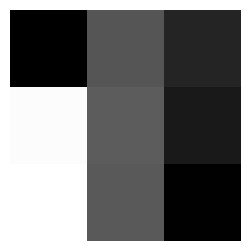

tensor([[[-0.1317, -0.2400, -0.1791],
         [ 0.4520,  0.2492,  0.1639],
         [-0.4566, -0.2454, -0.1340]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


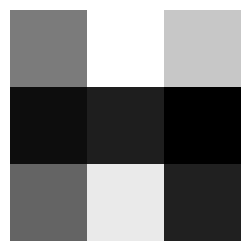

tensor([[[ 0.1942, -0.3759, -0.2977],
         [-0.0428, -0.0661, -0.0237],
         [-0.1624, -0.3470, -0.0680]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


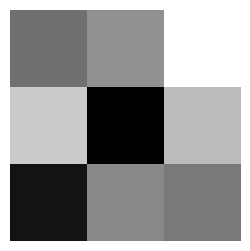

tensor([[[-0.2009, -0.2450, -0.3928],
         [ 0.3229, -0.0513,  0.3018],
         [ 0.0770, -0.2344,  0.2152]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


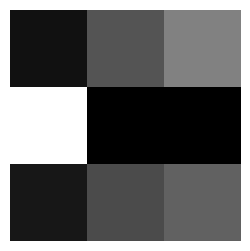

tensor([[[ 0.0557, -0.2236, -0.3382],
         [-0.6558,  0.0132, -0.0120],
         [ 0.0712, -0.2030,  0.2562]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


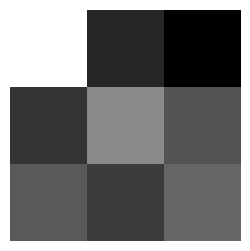

tensor([[[-0.4819, -0.0936,  0.0243],
         [ 0.1181,  0.2719,  0.1753],
         [-0.1847,  0.1311, -0.2072]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


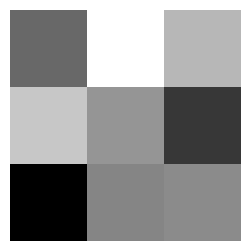

tensor([[[-0.1413, -0.3416,  0.2460],
         [-0.2674,  0.2005,  0.0763],
         [ 0.0031, -0.1800,  0.1869]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


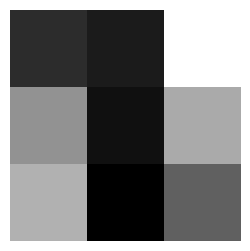

tensor([[[ 0.0872,  0.0672, -0.3232],
         [ 0.2004, -0.0551, -0.2281],
         [ 0.2358,  0.0370, -0.1451]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


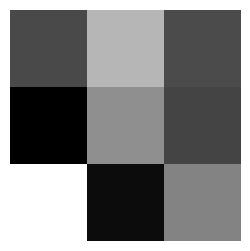

tensor([[[-0.0970, -0.2324,  0.0998],
         [ 0.0064, -0.1841, -0.0912],
         [-0.3235,  0.0220,  0.1707]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


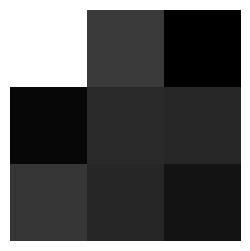

tensor([[[-0.3513,  0.0901,  0.0124],
         [ 0.0224, -0.0688,  0.0648],
         [ 0.0844,  0.0637, -0.0387]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


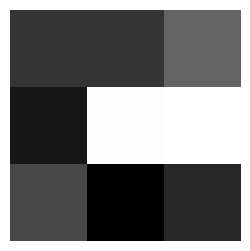

tensor([[[-0.0653,  0.0649, -0.1073],
         [-0.0385,  0.2434,  0.2458],
         [-0.0814, -0.0179, -0.0546]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


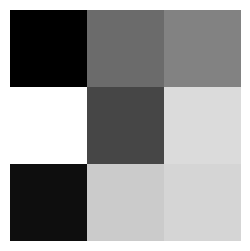

tensor([[[ 0.0196,  0.1748,  0.2081],
         [-0.3890, -0.1219,  0.3365],
         [ 0.0408, -0.3129, -0.3273]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


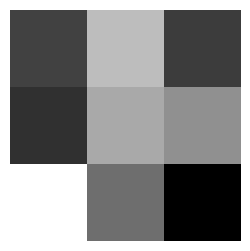

tensor([[[-0.1450, -0.3793, -0.1352],
         [ 0.1116,  0.3406,  0.2933],
         [-0.5061, -0.2295, -0.0191]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


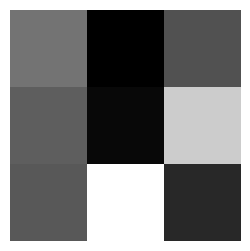

tensor([[[ 0.2077,  0.0824, -0.1704],
         [ 0.1847, -0.0915, -0.3037],
         [ 0.1778, -0.3591, -0.1275]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


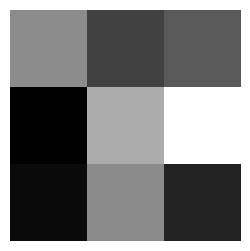

tensor([[[-0.3696,  0.2226,  0.2720],
         [ 0.0935, -0.4332, -0.5967],
         [-0.1142,  0.3672,  0.1608]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


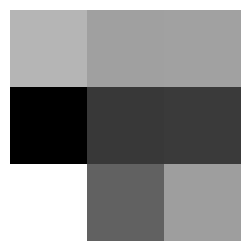

tensor([[[ 0.2791,  0.2479,  0.2504],
         [-0.0146, -0.0981, -0.1003],
         [-0.3875, -0.1584, -0.2455]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


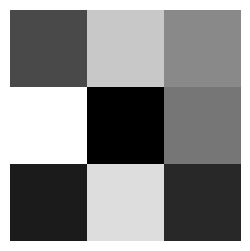

tensor([[[ 0.1578, -0.3139, -0.2361],
         [-0.3825, -0.0674,  0.2132],
         [-0.1007,  0.3401, -0.1179]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


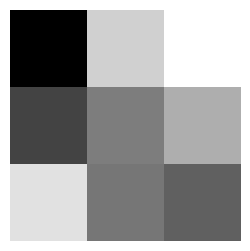

tensor([[[-0.0242, -0.2687, -0.3250],
         [-0.1040, -0.1720,  0.2294],
         [-0.2891,  0.1635,  0.1373]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


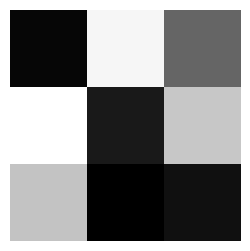

tensor([[[ 0.0647, -0.3086,  0.1612],
         [-0.3181,  0.0848,  0.2607],
         [-0.2564, -0.0586, -0.0753]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


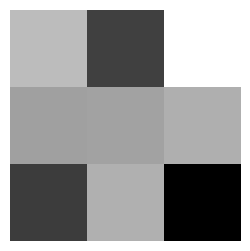

tensor([[[-0.3145,  0.1138, -0.4234],
         [ 0.2700,  0.2718,  0.2929],
         [-0.1089, -0.2948, -0.0103]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


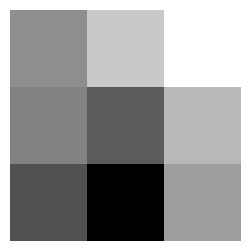

tensor([[[ 0.2437, -0.3293, -0.4086],
         [-0.2253, -0.1692, -0.3063],
         [-0.1552,  0.0359, -0.2668]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


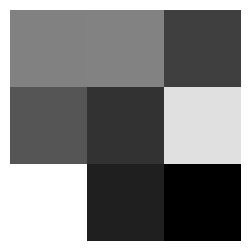

tensor([[[ 0.2219,  0.2224, -0.1122],
         [-0.1480, -0.0908, -0.3786],
         [-0.4306,  0.0603,  0.0075]]], device='cuda:0',
       grad_fn=<UnbindBackward0>)


In [17]:
print("Free weights layer one:")
for weight in model.conv1_free.weight:
    kernel = np.abs(weight.reshape(3, 3).detach().cpu().numpy())
    
    plt.figure(figsize=(3, 3))
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')
    plt.show()
    print(weight)

/tmp/ipykernel_25211/2723124601.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.98])


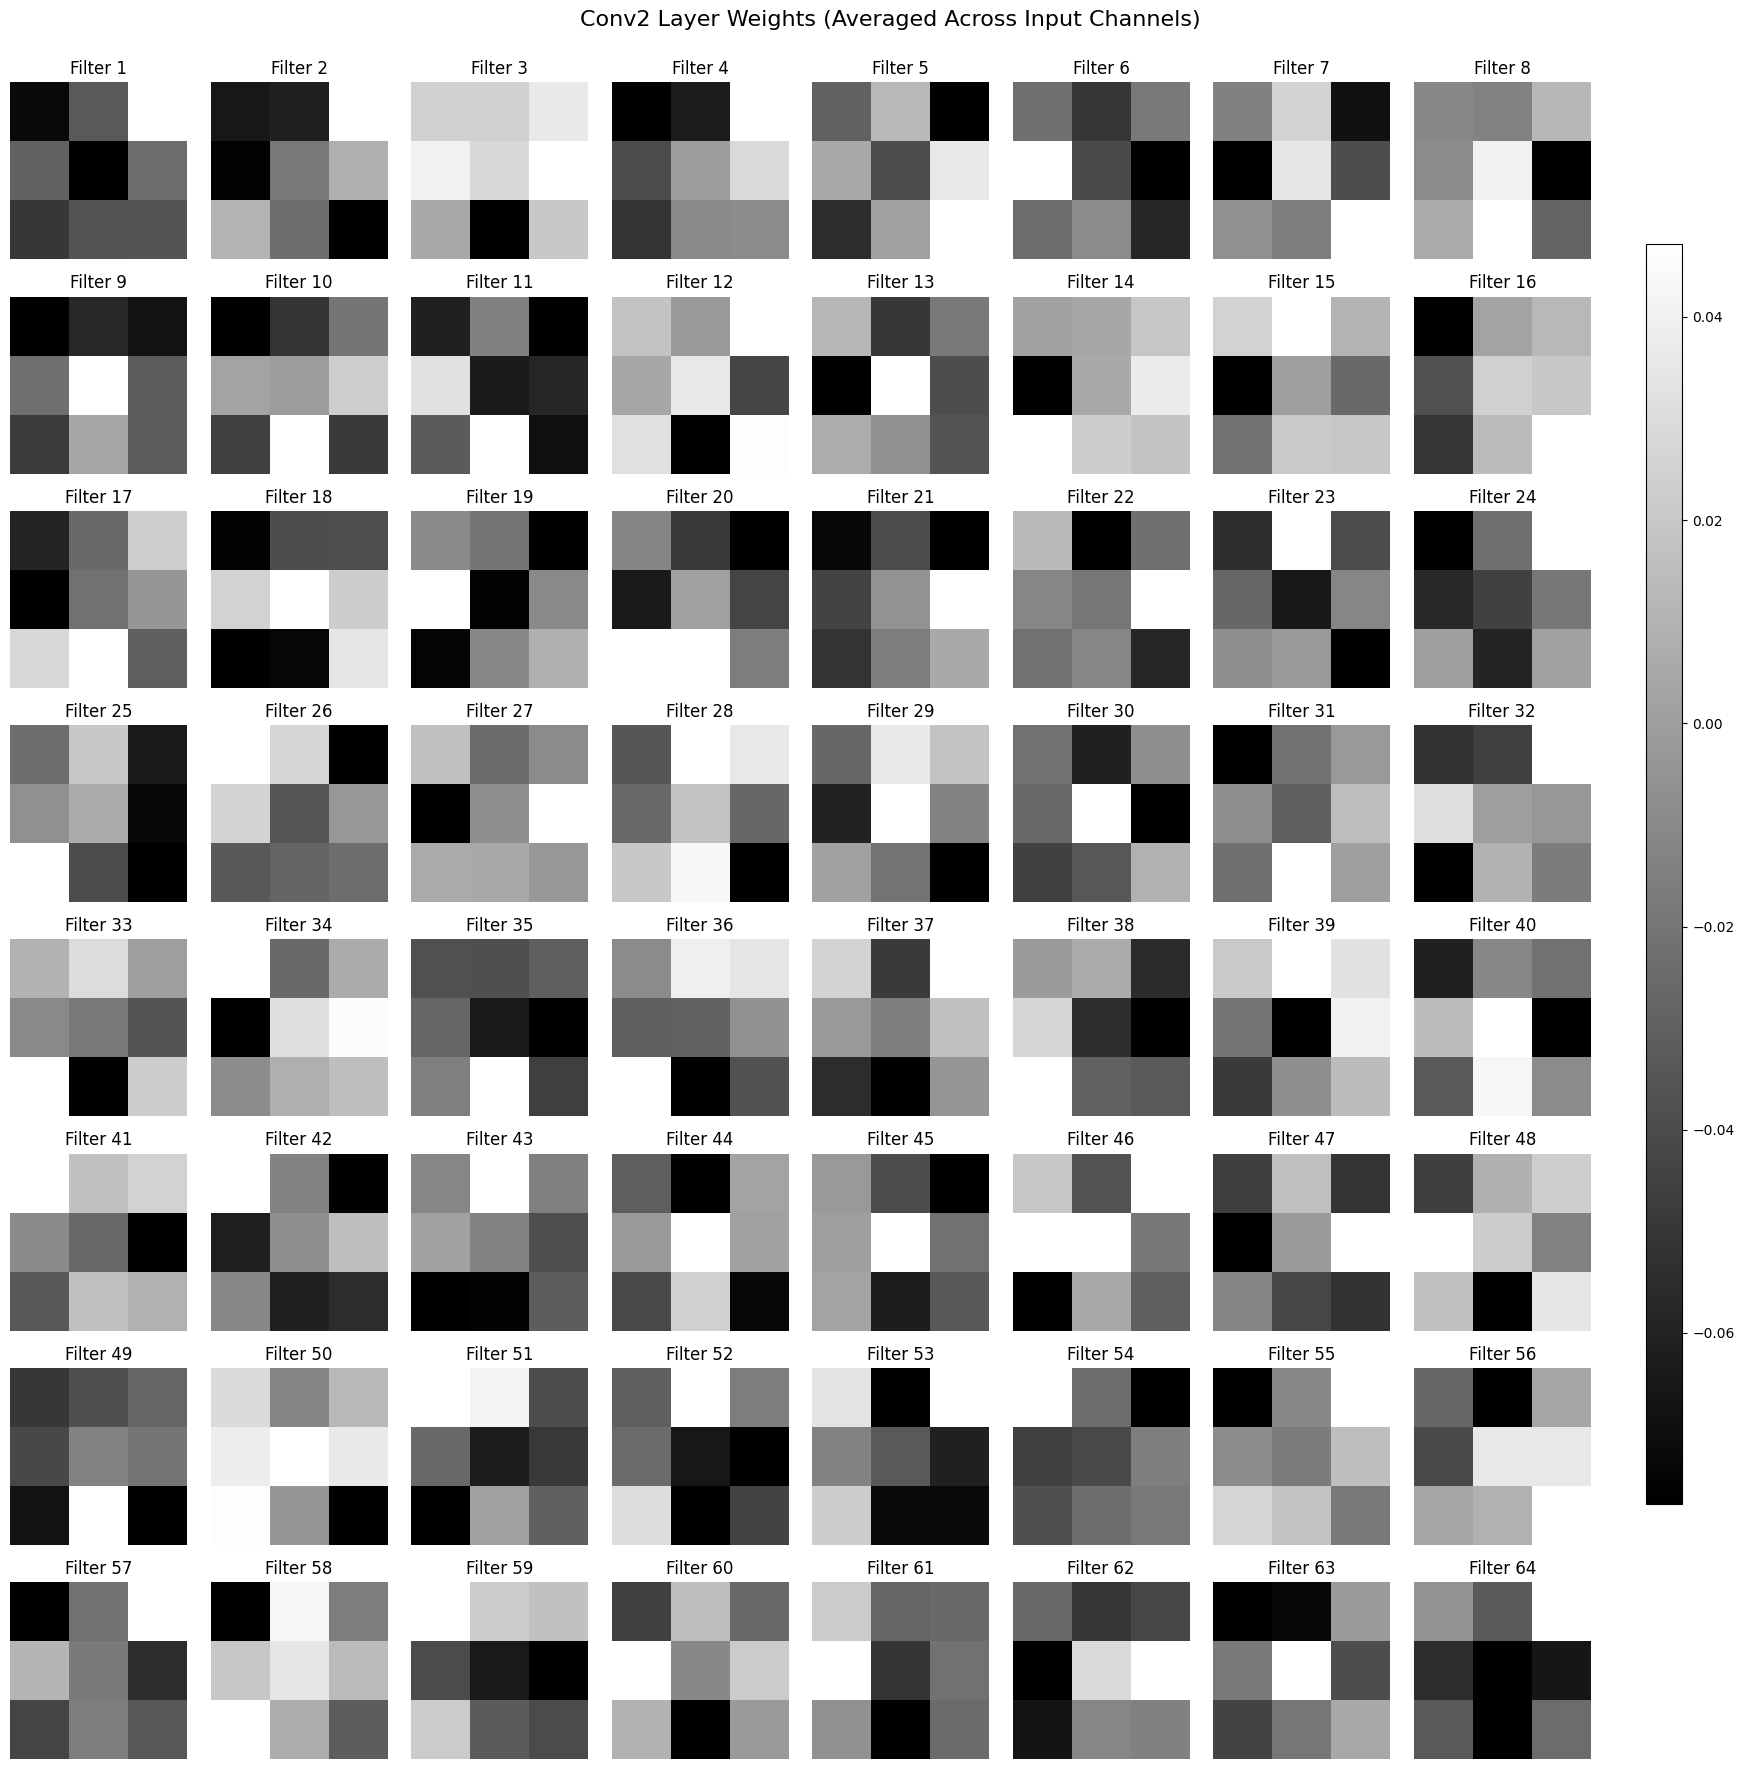

In [18]:
weights = model.conv2.weight.data.cpu().numpy()

# Set up the figure
fig, axs = plt.subplots(8, 8, figsize=(18, 18))  # 8x8 grid for 64 output channels
fig.subplots_adjust(hspace=0.8, wspace=0.8)

# Loop through all 64 output channels
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        if idx < weights.shape[0]:  # Make sure we don't exceed the number of filters
            # For each output filter, we take the average across input channels
            # This gives us a single 3x3 kernel to visualize
            filter_weights = np.mean(weights[idx], axis=0)
            
            # Plot the filter
            im = axs[i, j].imshow(filter_weights, cmap="gray")
            axs[i, j].set_title(f'Filter {idx+1}')
            axs[i, j].axis('off')

# plt.colorbar(im, ax=axs)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('Conv2 Layer Weights (Averaged Across Input Channels)', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.98])
plt.show()

## Seeing Activations

In [19]:
model.eval()
eval_examples = list()
with torch.no_grad():
    for idx, img in enumerate(test_images[:10]):
        img_tensor = torch.from_numpy(img.copy()).float().unsqueeze(0).unsqueeze(0).to('cuda')
        out, interp_1, interp_2, conv_act = model(img_tensor)

        # Process each channel separately
        v_act_imgs = []
        h_act_imgs = []
        other_act_imgs = []
            
        # Process horizontal edge filters
        for i in range(interp_1.size(1)):  # Loop through channels
            h_channel = interp_1[0, i].detach().cpu().numpy()
            h_act_imgs.append(h_channel)

        # Process vertical edge filters
        for i in range(interp_2.size(1)):  # Loop through channels
            v_channel = interp_2[0, i].detach().cpu().numpy()
            v_act_imgs.append(v_channel)

        # Process unrestricted filters
        for i in range(conv_act.size(1)):  # Loop through channels
            o_channel = conv_act[0, i].detach().cpu().numpy()
            other_act_imgs.append(o_channel)

        label = test_labels[idx]
        eval_examples.append((label, img, out, v_act_imgs, h_act_imgs, other_act_imgs))

In [38]:
def visualize_kernel_activations(img, label, v_act_imgs, h_act_imgs, other_act_imgs, prediction=None):
    """
    Visualize the original image and the activations from interpretable kernels.
    
    Args:
        img: Original input image
        label: True label
        v_act_imgs: List of vertical edge filter activations
        h_act_imgs: List of horizontal edge filter activations
        prediction: Model's prediction (optional)
    """
    # Determine number of filters
    n_v_filters = len(v_act_imgs)
    n_h_filters = len(h_act_imgs)
    n_other_filters = len(other_act_imgs)
    
    # Calculate rows needed for unrestricted filters (4 per row)
    n_other_rows = (n_other_filters + 3) // 4  # Ceiling division
    
    # Total rows: 2 for interpretable filters + rows for unrestricted filters
    total_rows = 2 + n_other_rows
    
    # Create figure with subplots
    fig, axes = plt.subplots(total_rows, 5, figsize=(20, 5 * total_rows))
    
    # Display original image
    axes[0, 0].imshow(img, cmap='gray')
    title = f"Original (Label: {label})"
    if prediction is not None:
        pred_label = np.argmax(prediction.detach().cpu().numpy())
        title += f"\nPredicted: {pred_label}"
    axes[0, 0].set_title(title)
    axes[0, 0].axis('off')
    
    axes[1, 0].axis('off')  # Empty spot in the grid
    
    # Display vertical edge filter activations
    for i in range(n_v_filters):
        axes[0, i+1].imshow(v_act_imgs[i], cmap='gray')
        axes[0, i+1].set_title(f"V-Filter {i+1}")
        axes[0, i+1].axis('off')
    
    # Display horizontal edge filter activations
    for i in range(n_h_filters):
        axes[1, i+1].imshow(h_act_imgs[i], cmap='gray')
        axes[1, i+1].set_title(f"H-Filter {i+1}")
        axes[1, i+1].axis('off')

    for row in range(2):
        for col in range(max(n_v_filters, n_h_filters) + 1, 5):
            axes[row, col].axis('off')

    # Display unrestricted filter activations, 4 per row
    for i in range(n_other_filters):
        row = 2 + (i // 4)  # Integer division to determine row
        col = i % 4 + 1     # Modulo to determine column (starting from 1)

        if row < axes.shape[0] and col < axes.shape[1]:
            axes[row, col].imshow(other_act_imgs[i], cmap='gray')
            axes[row, col].set_title(f"U-Filter {i+1}")
            axes[row, col].axis('off')
        
            # First column of each unrestricted filter row is empty
            axes[row, 0].axis('off')
    
    plt.tight_layout()

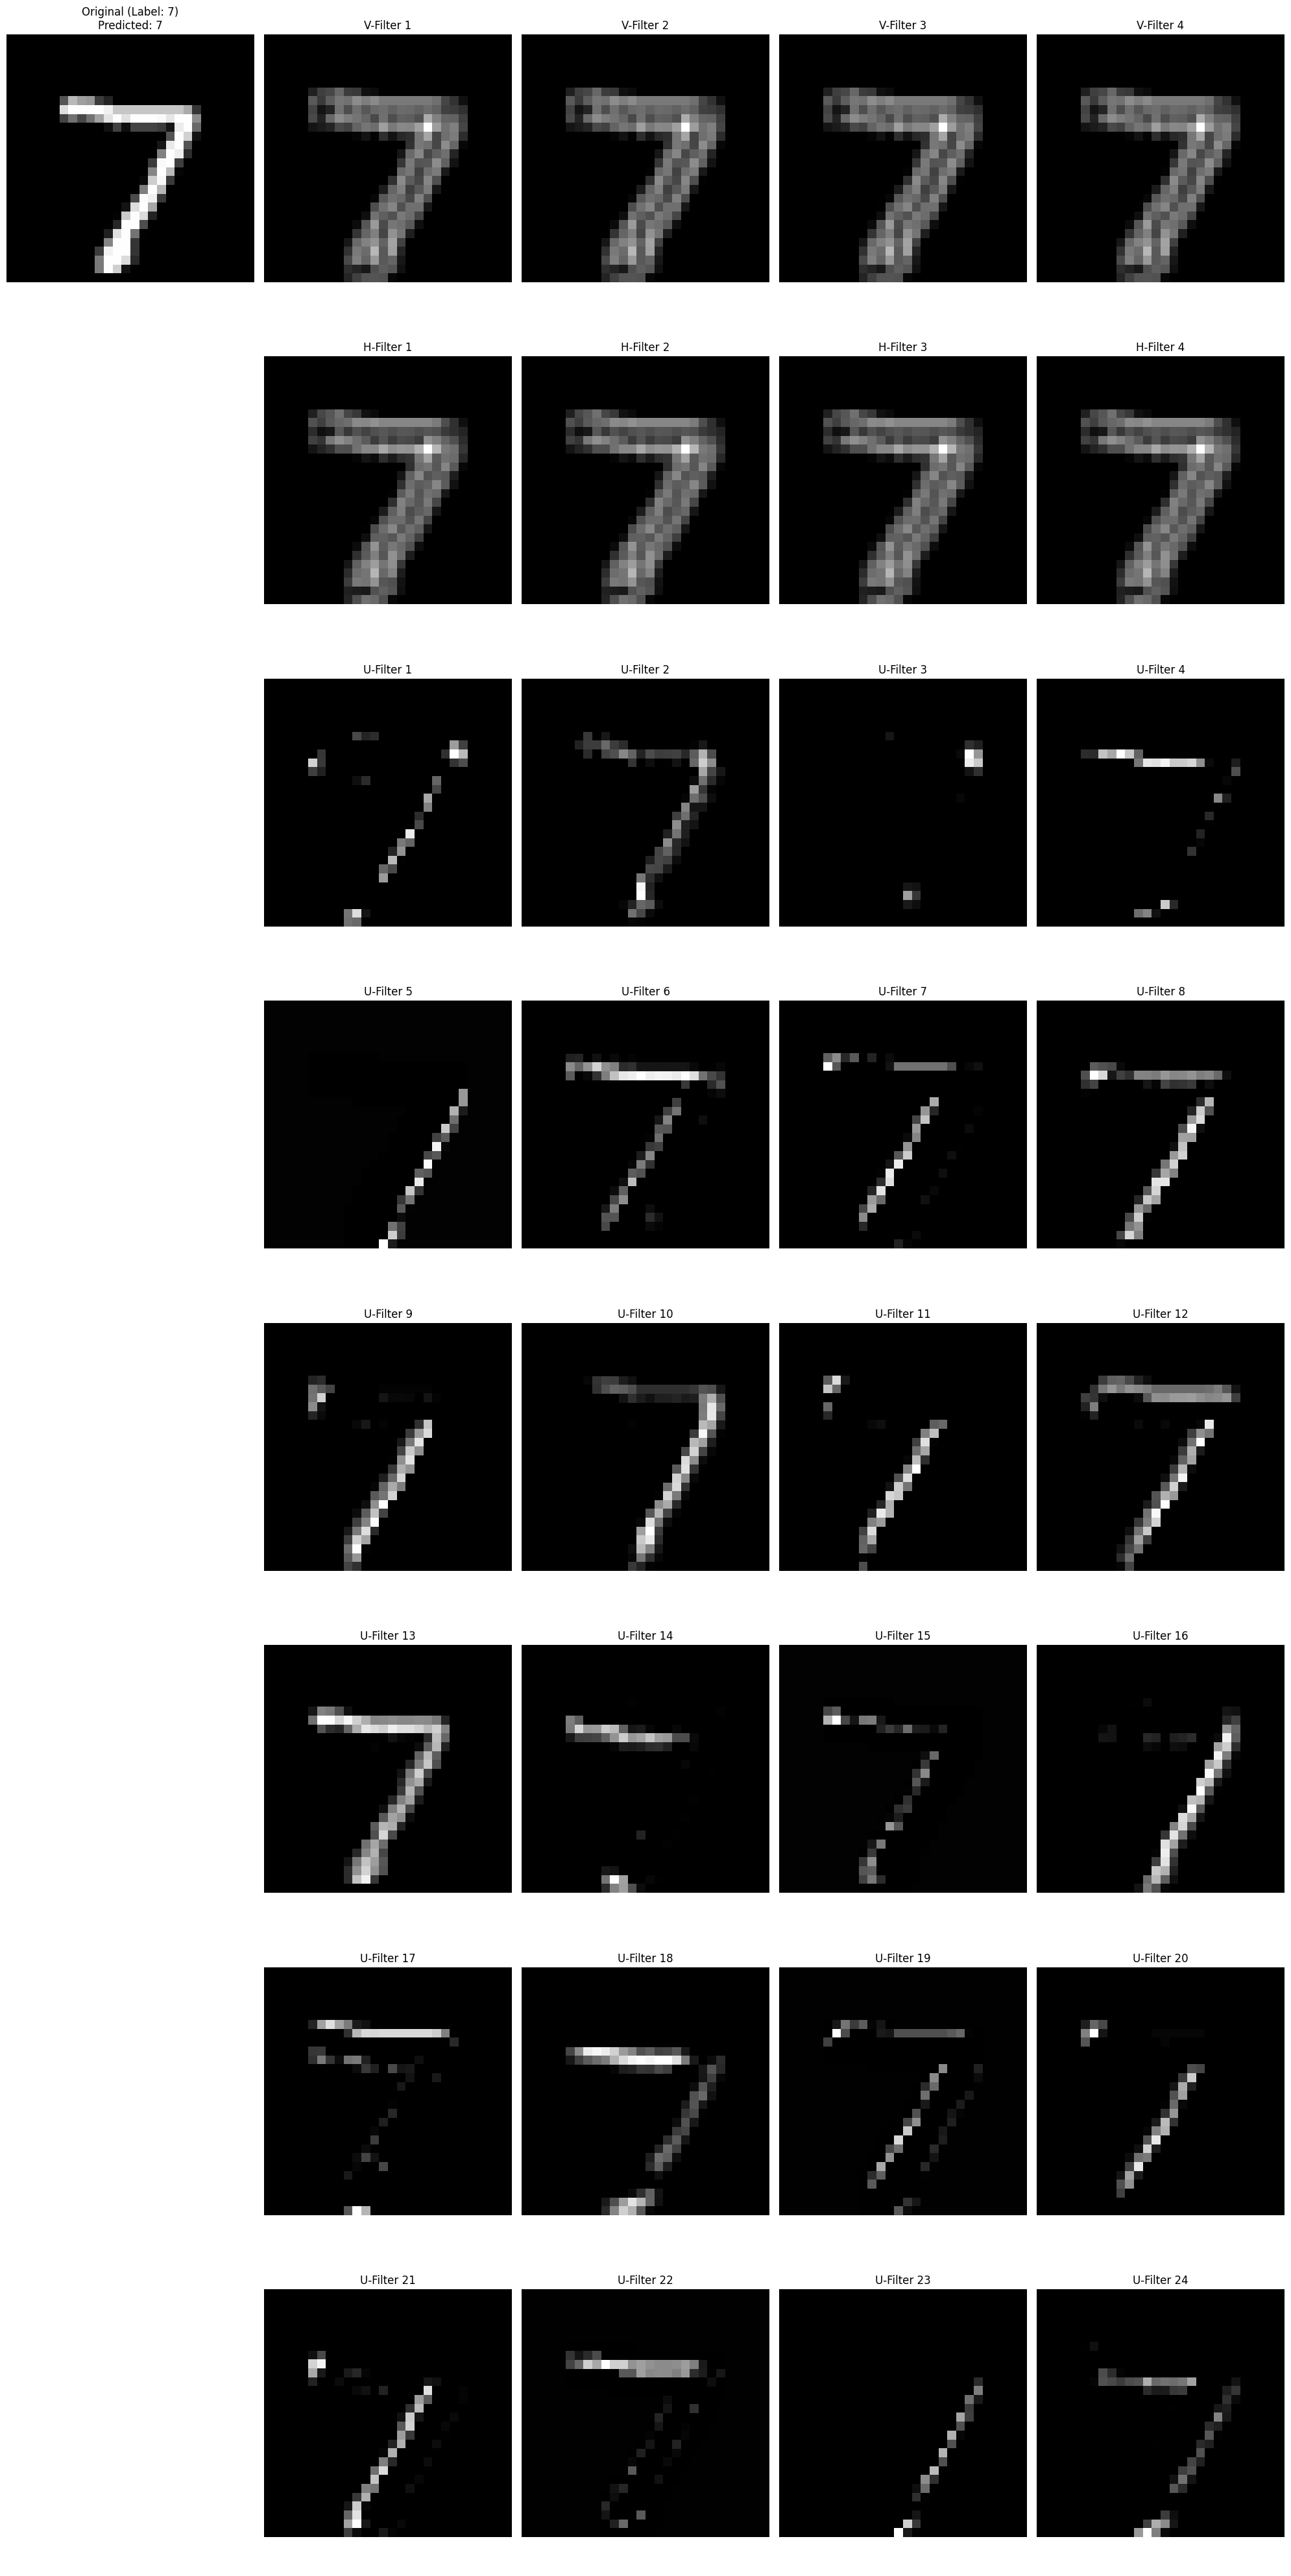

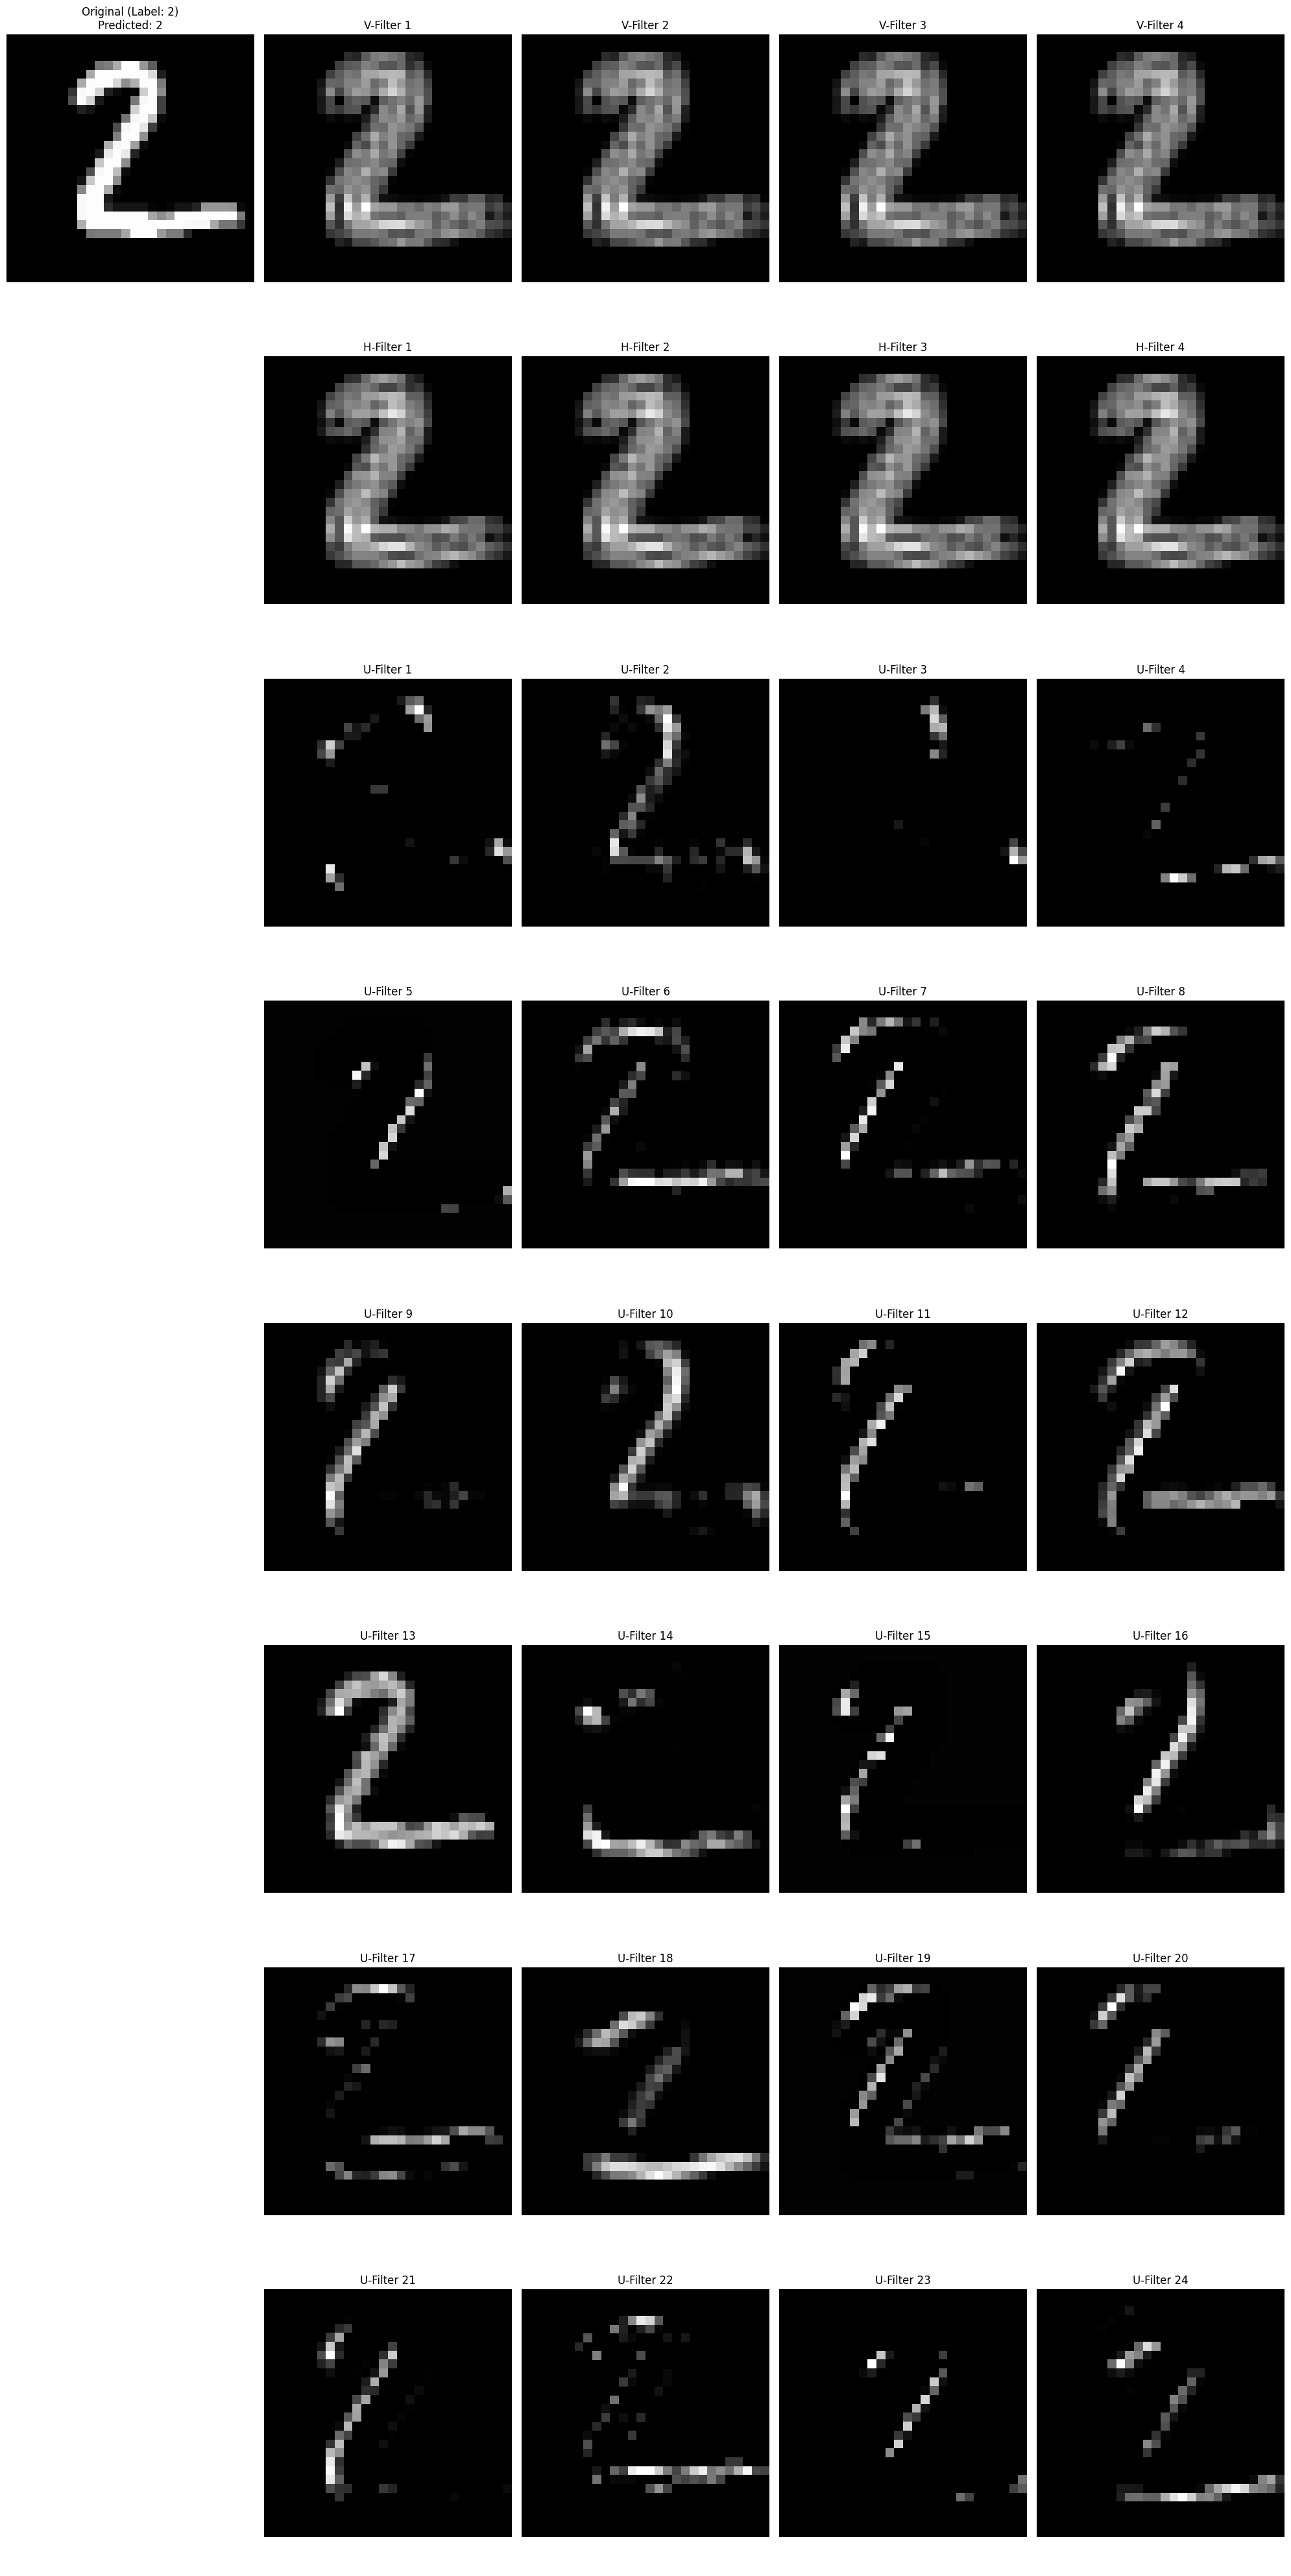

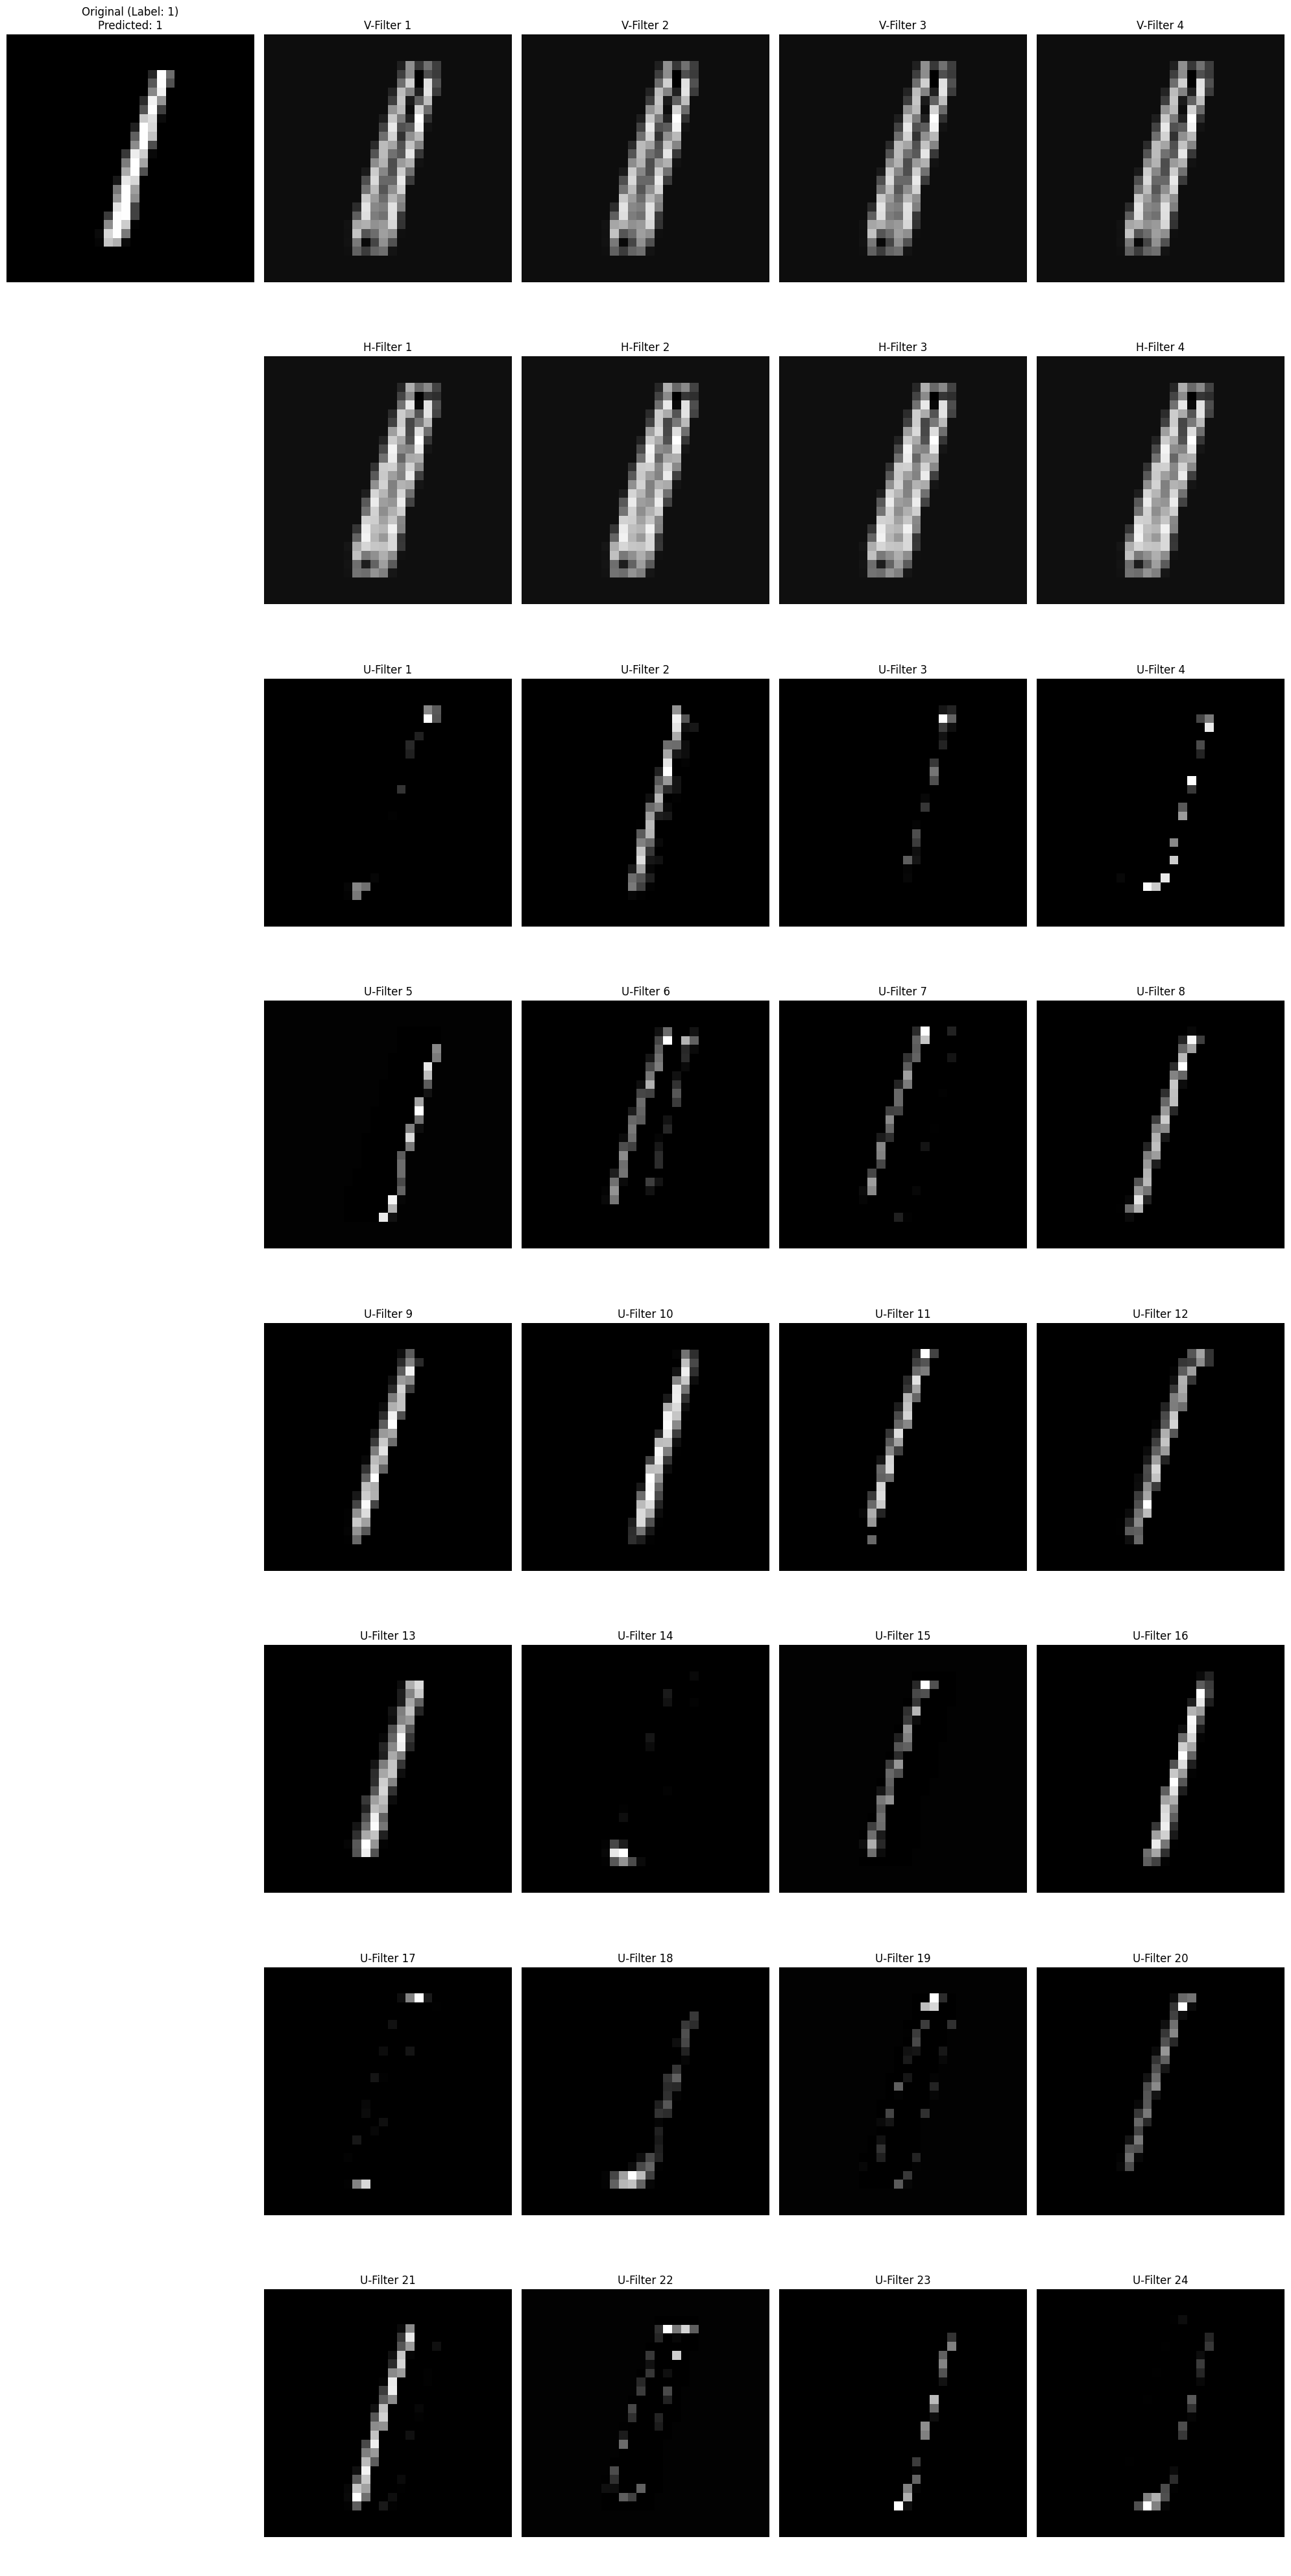

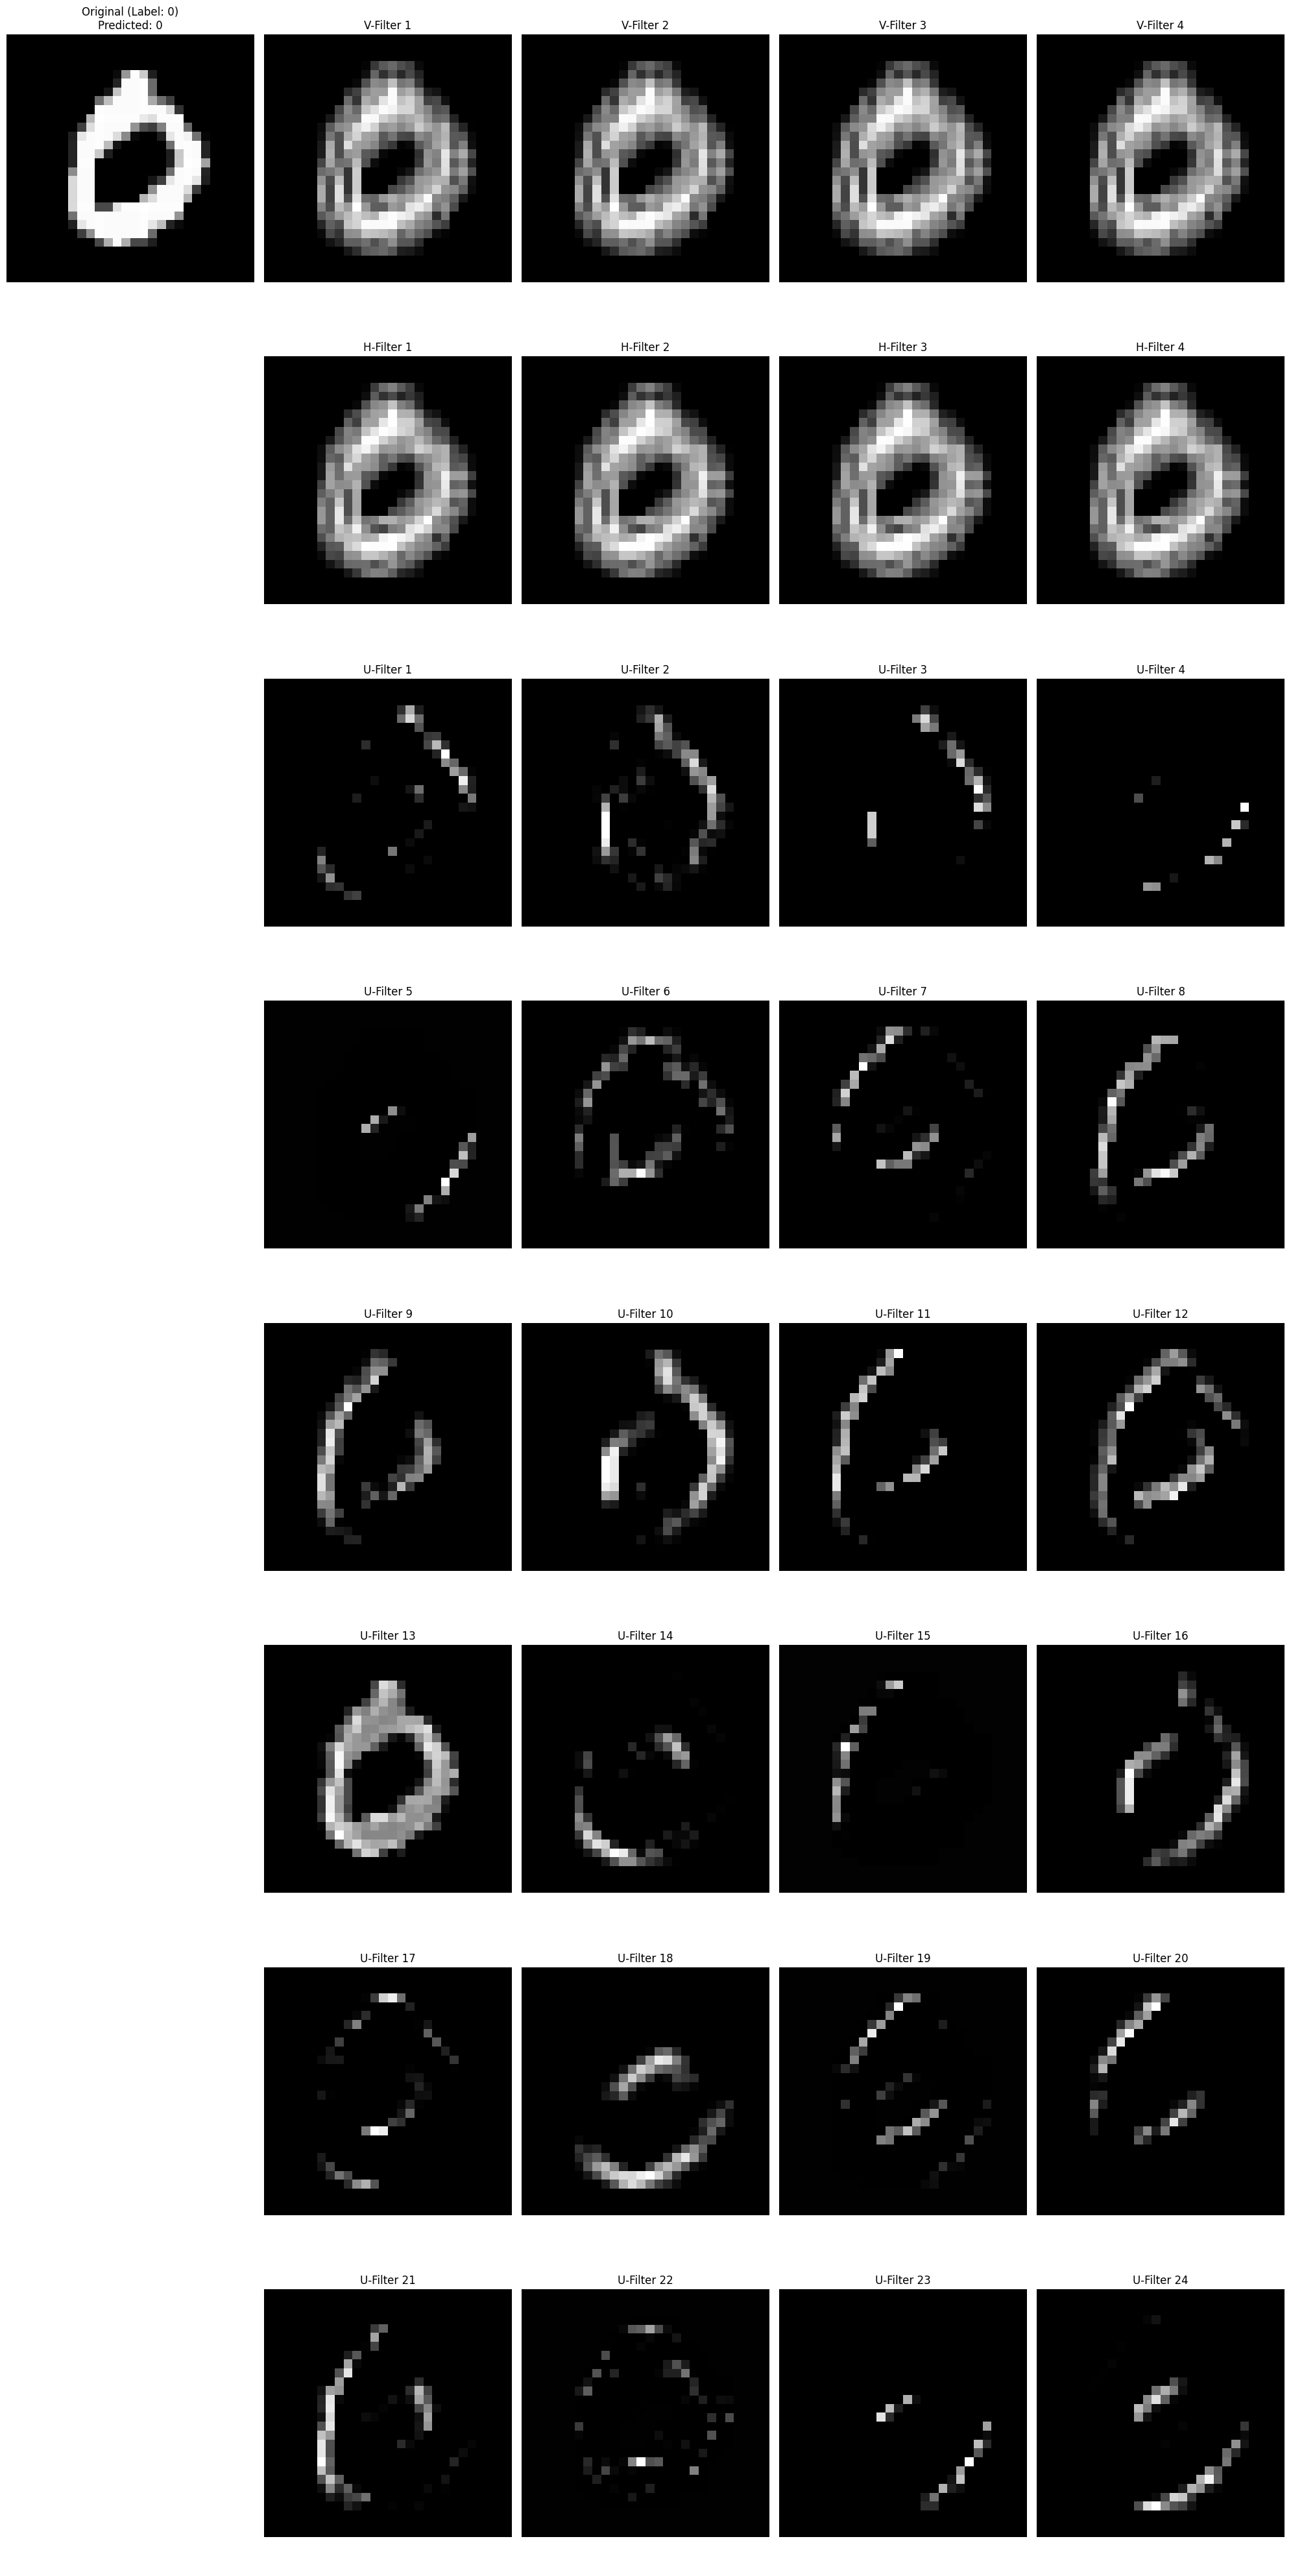

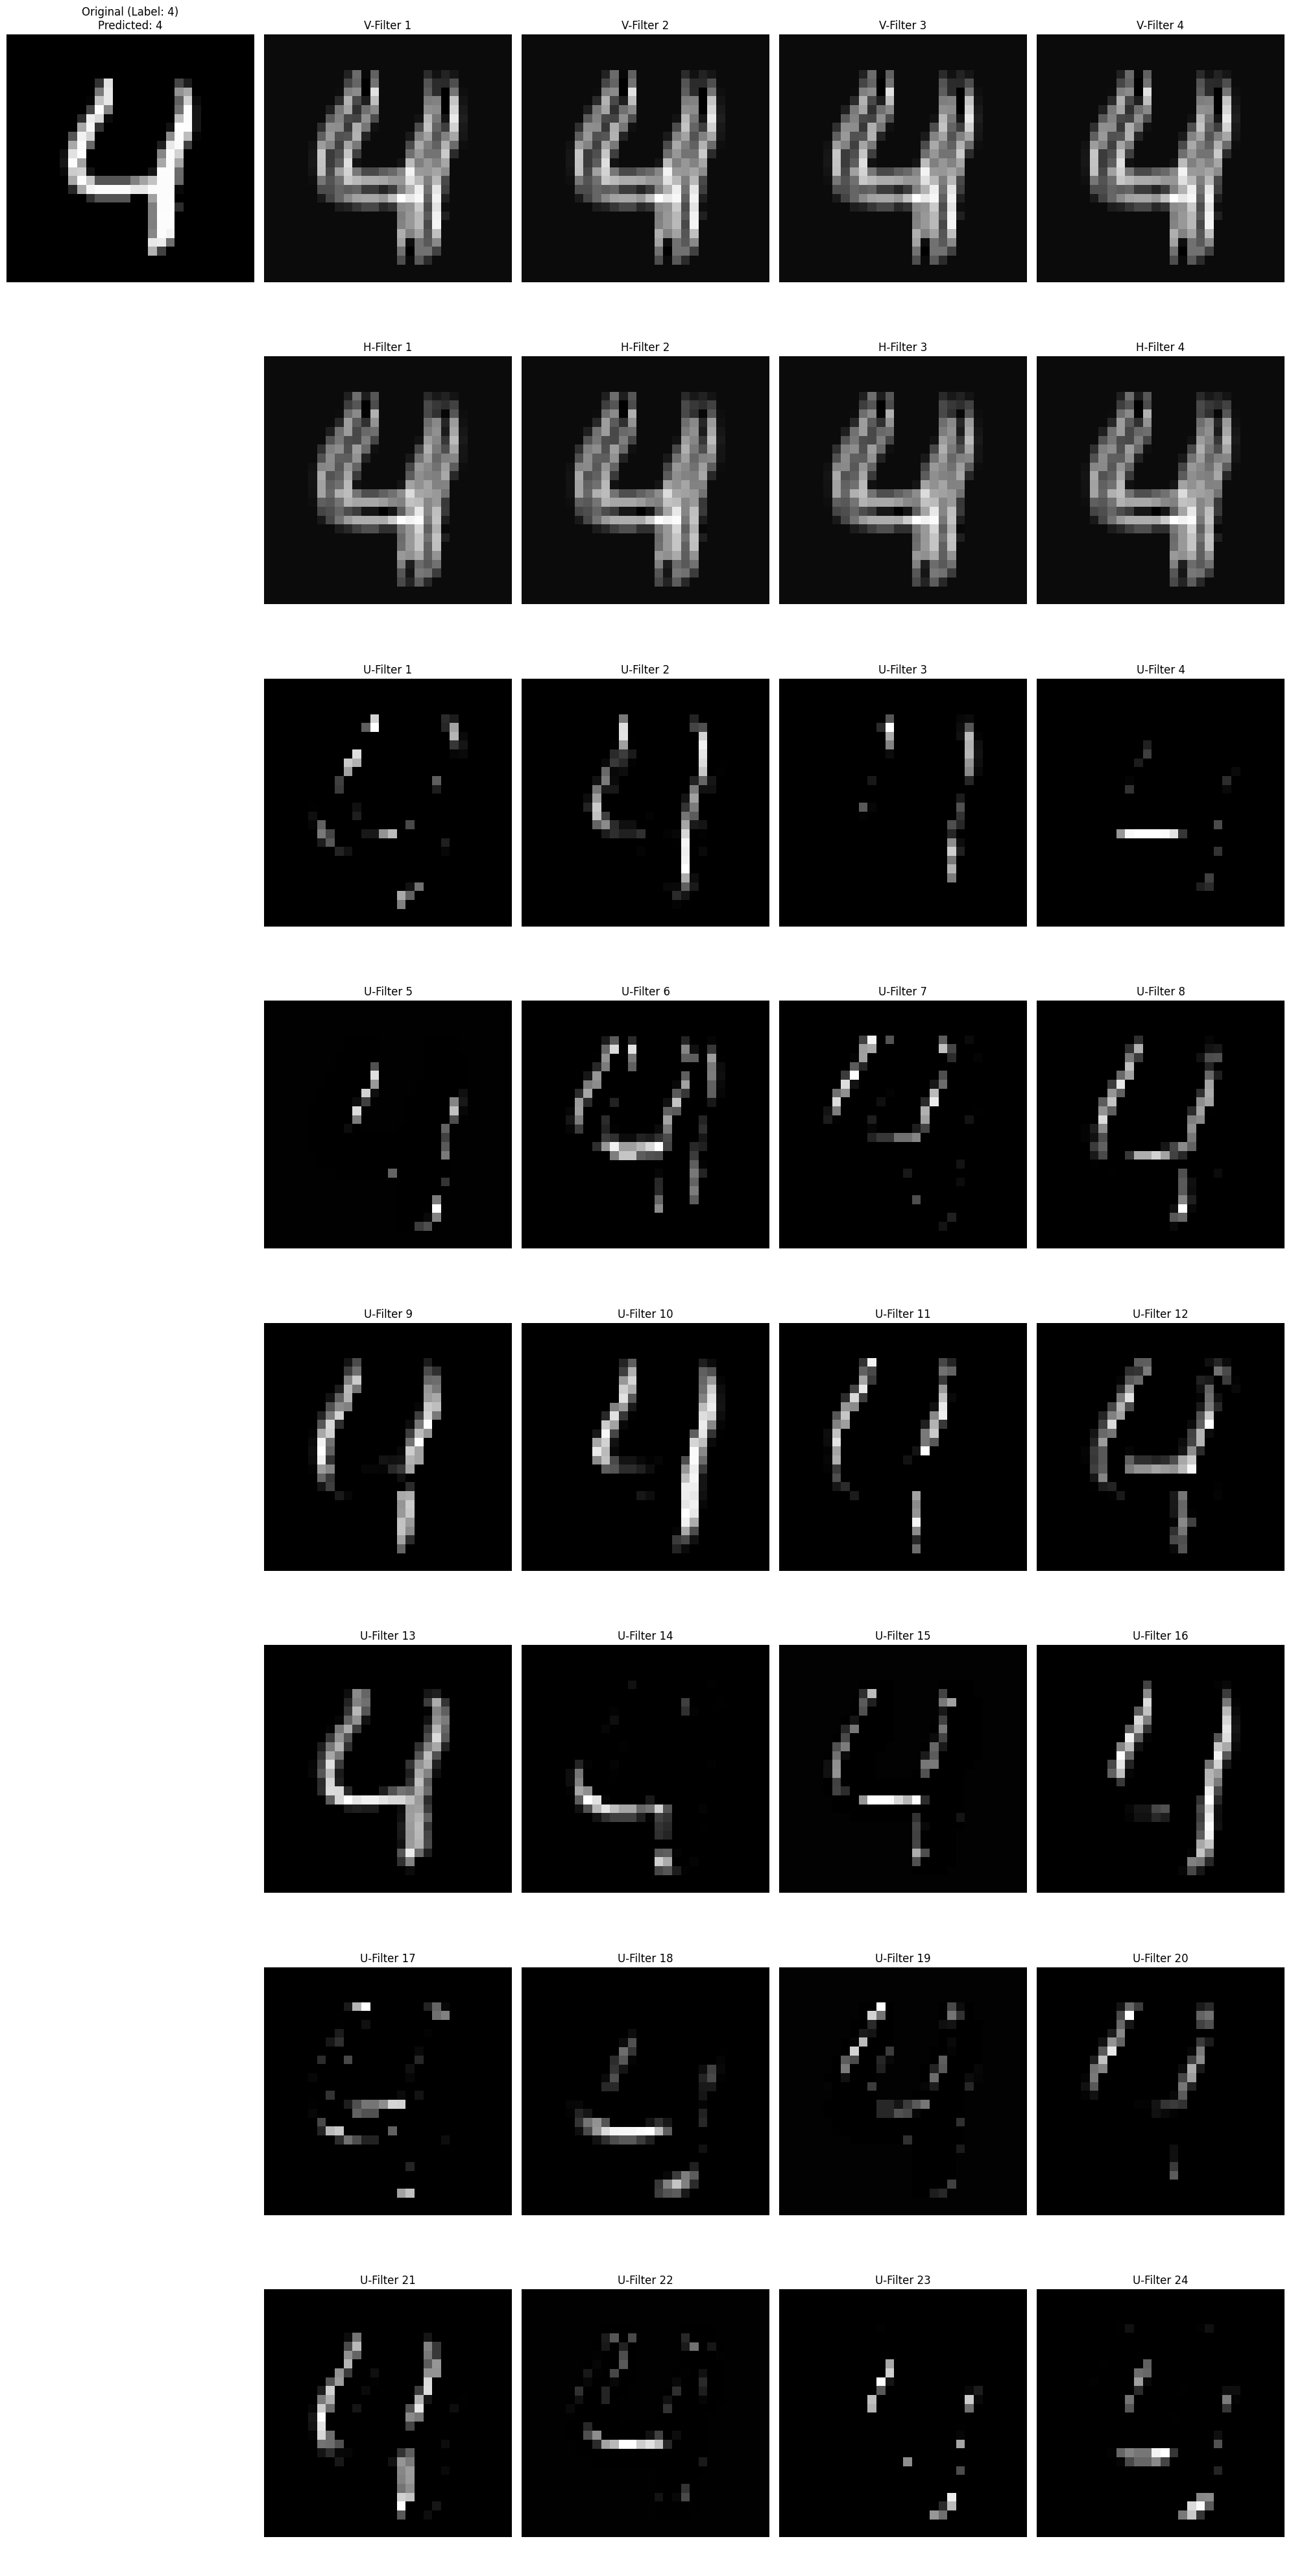

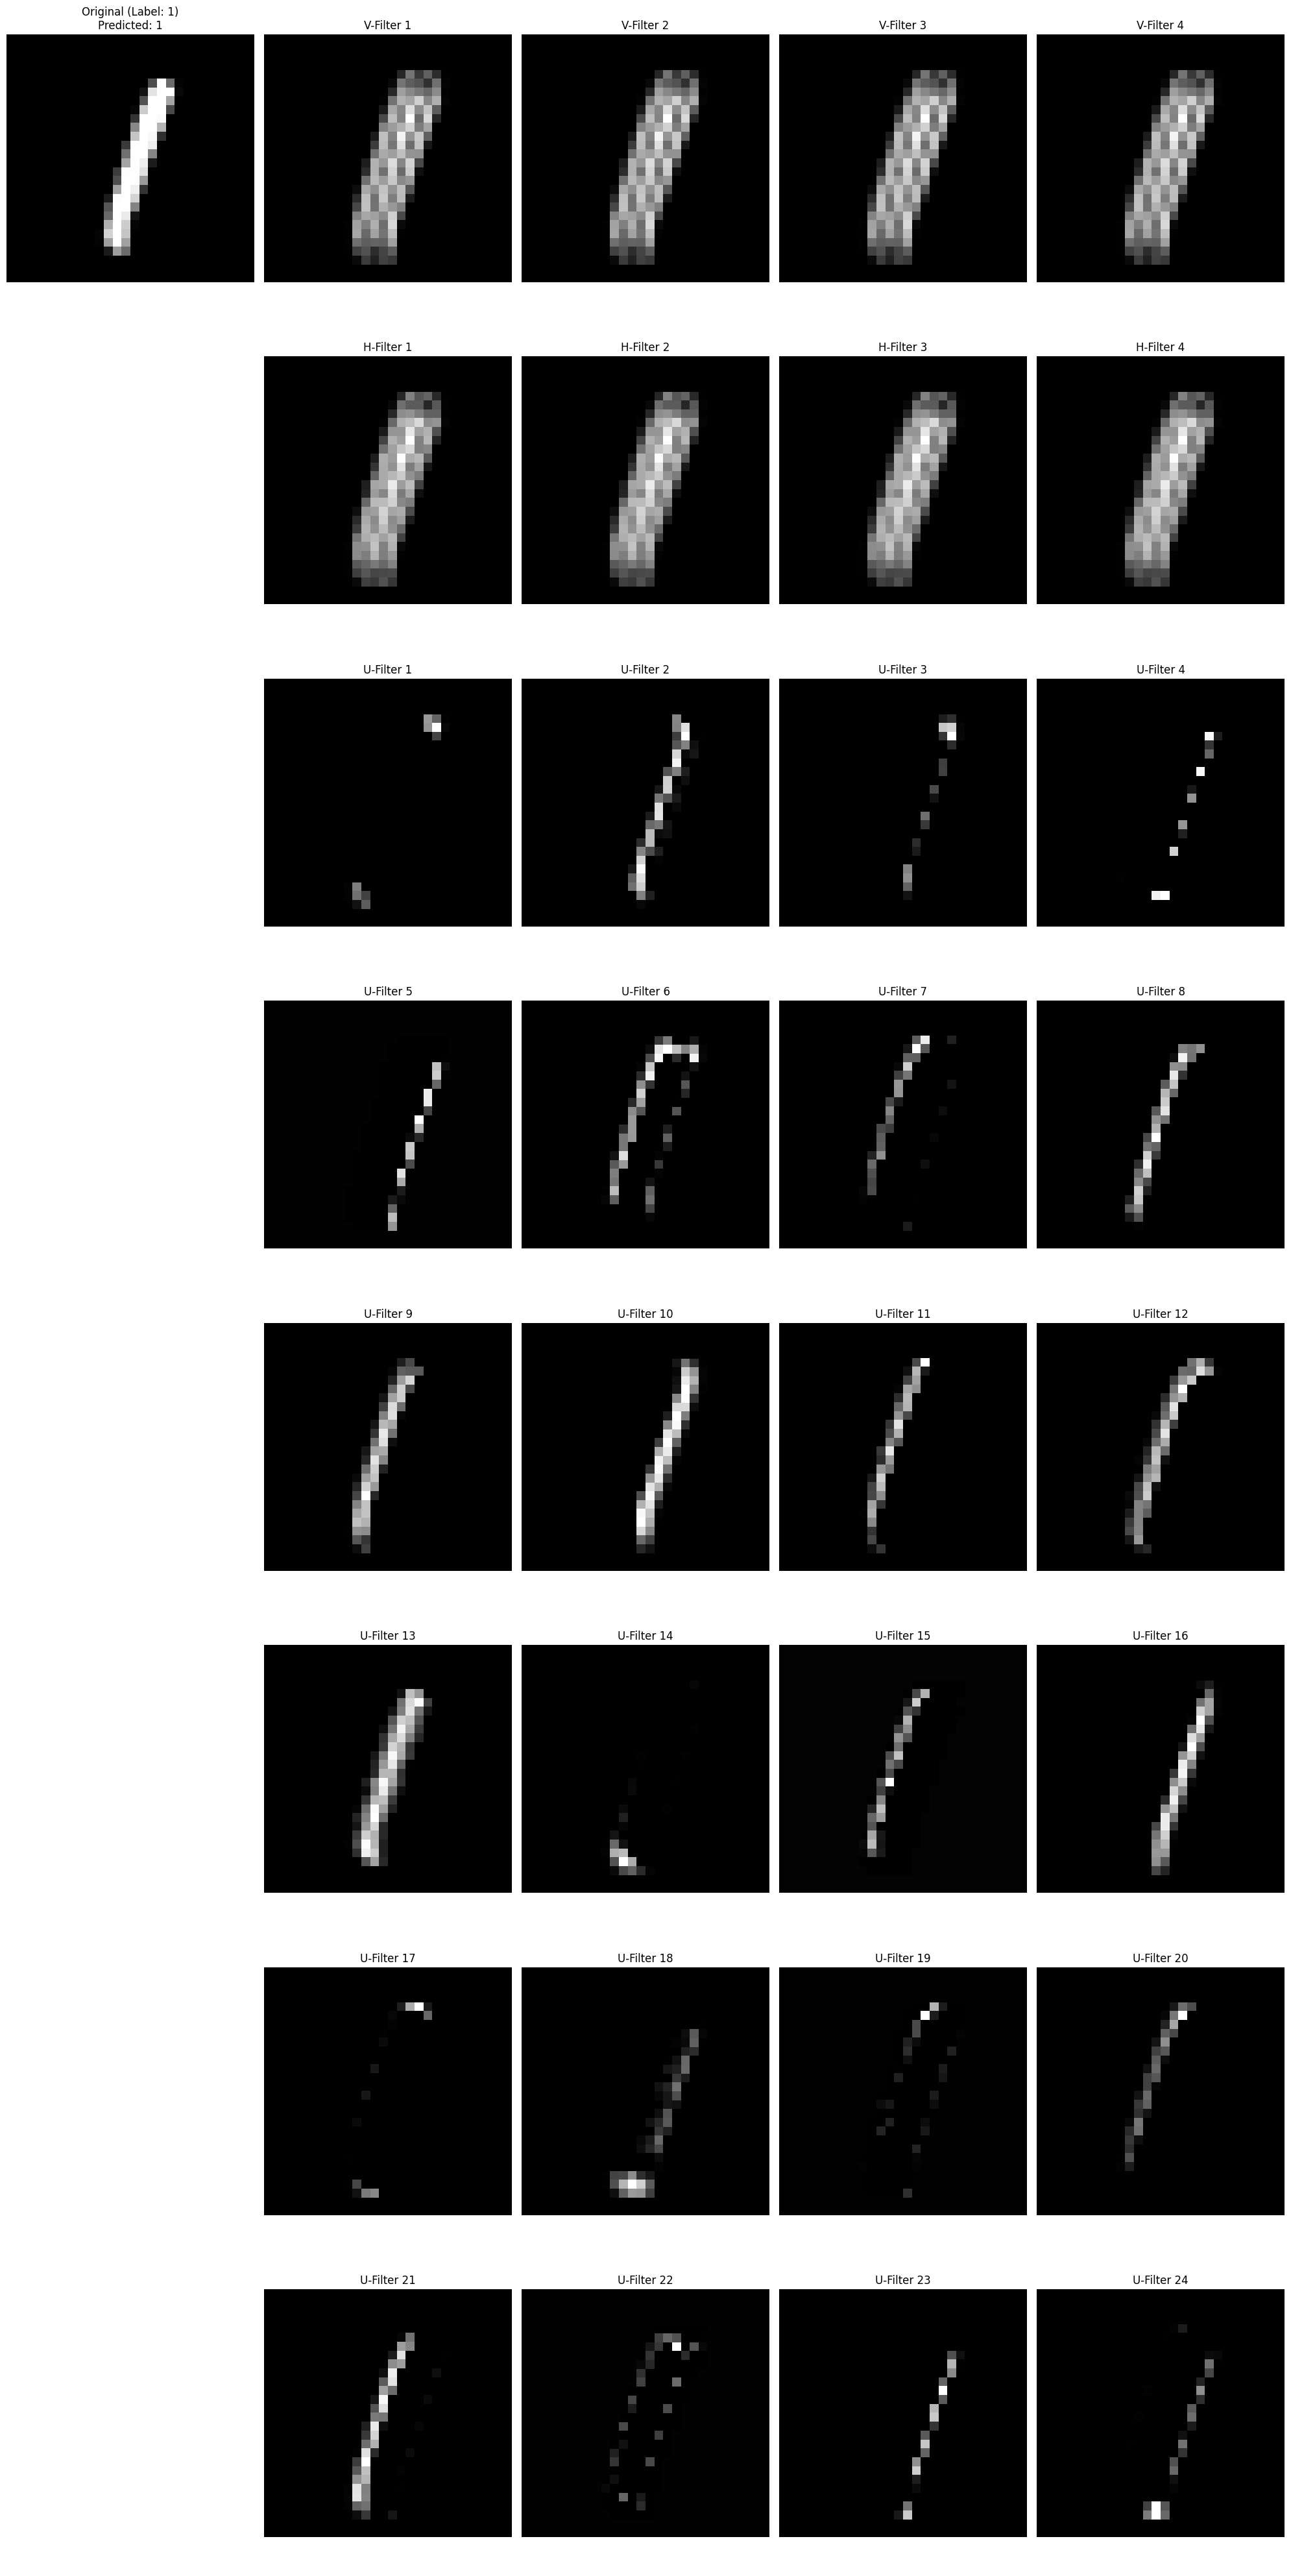

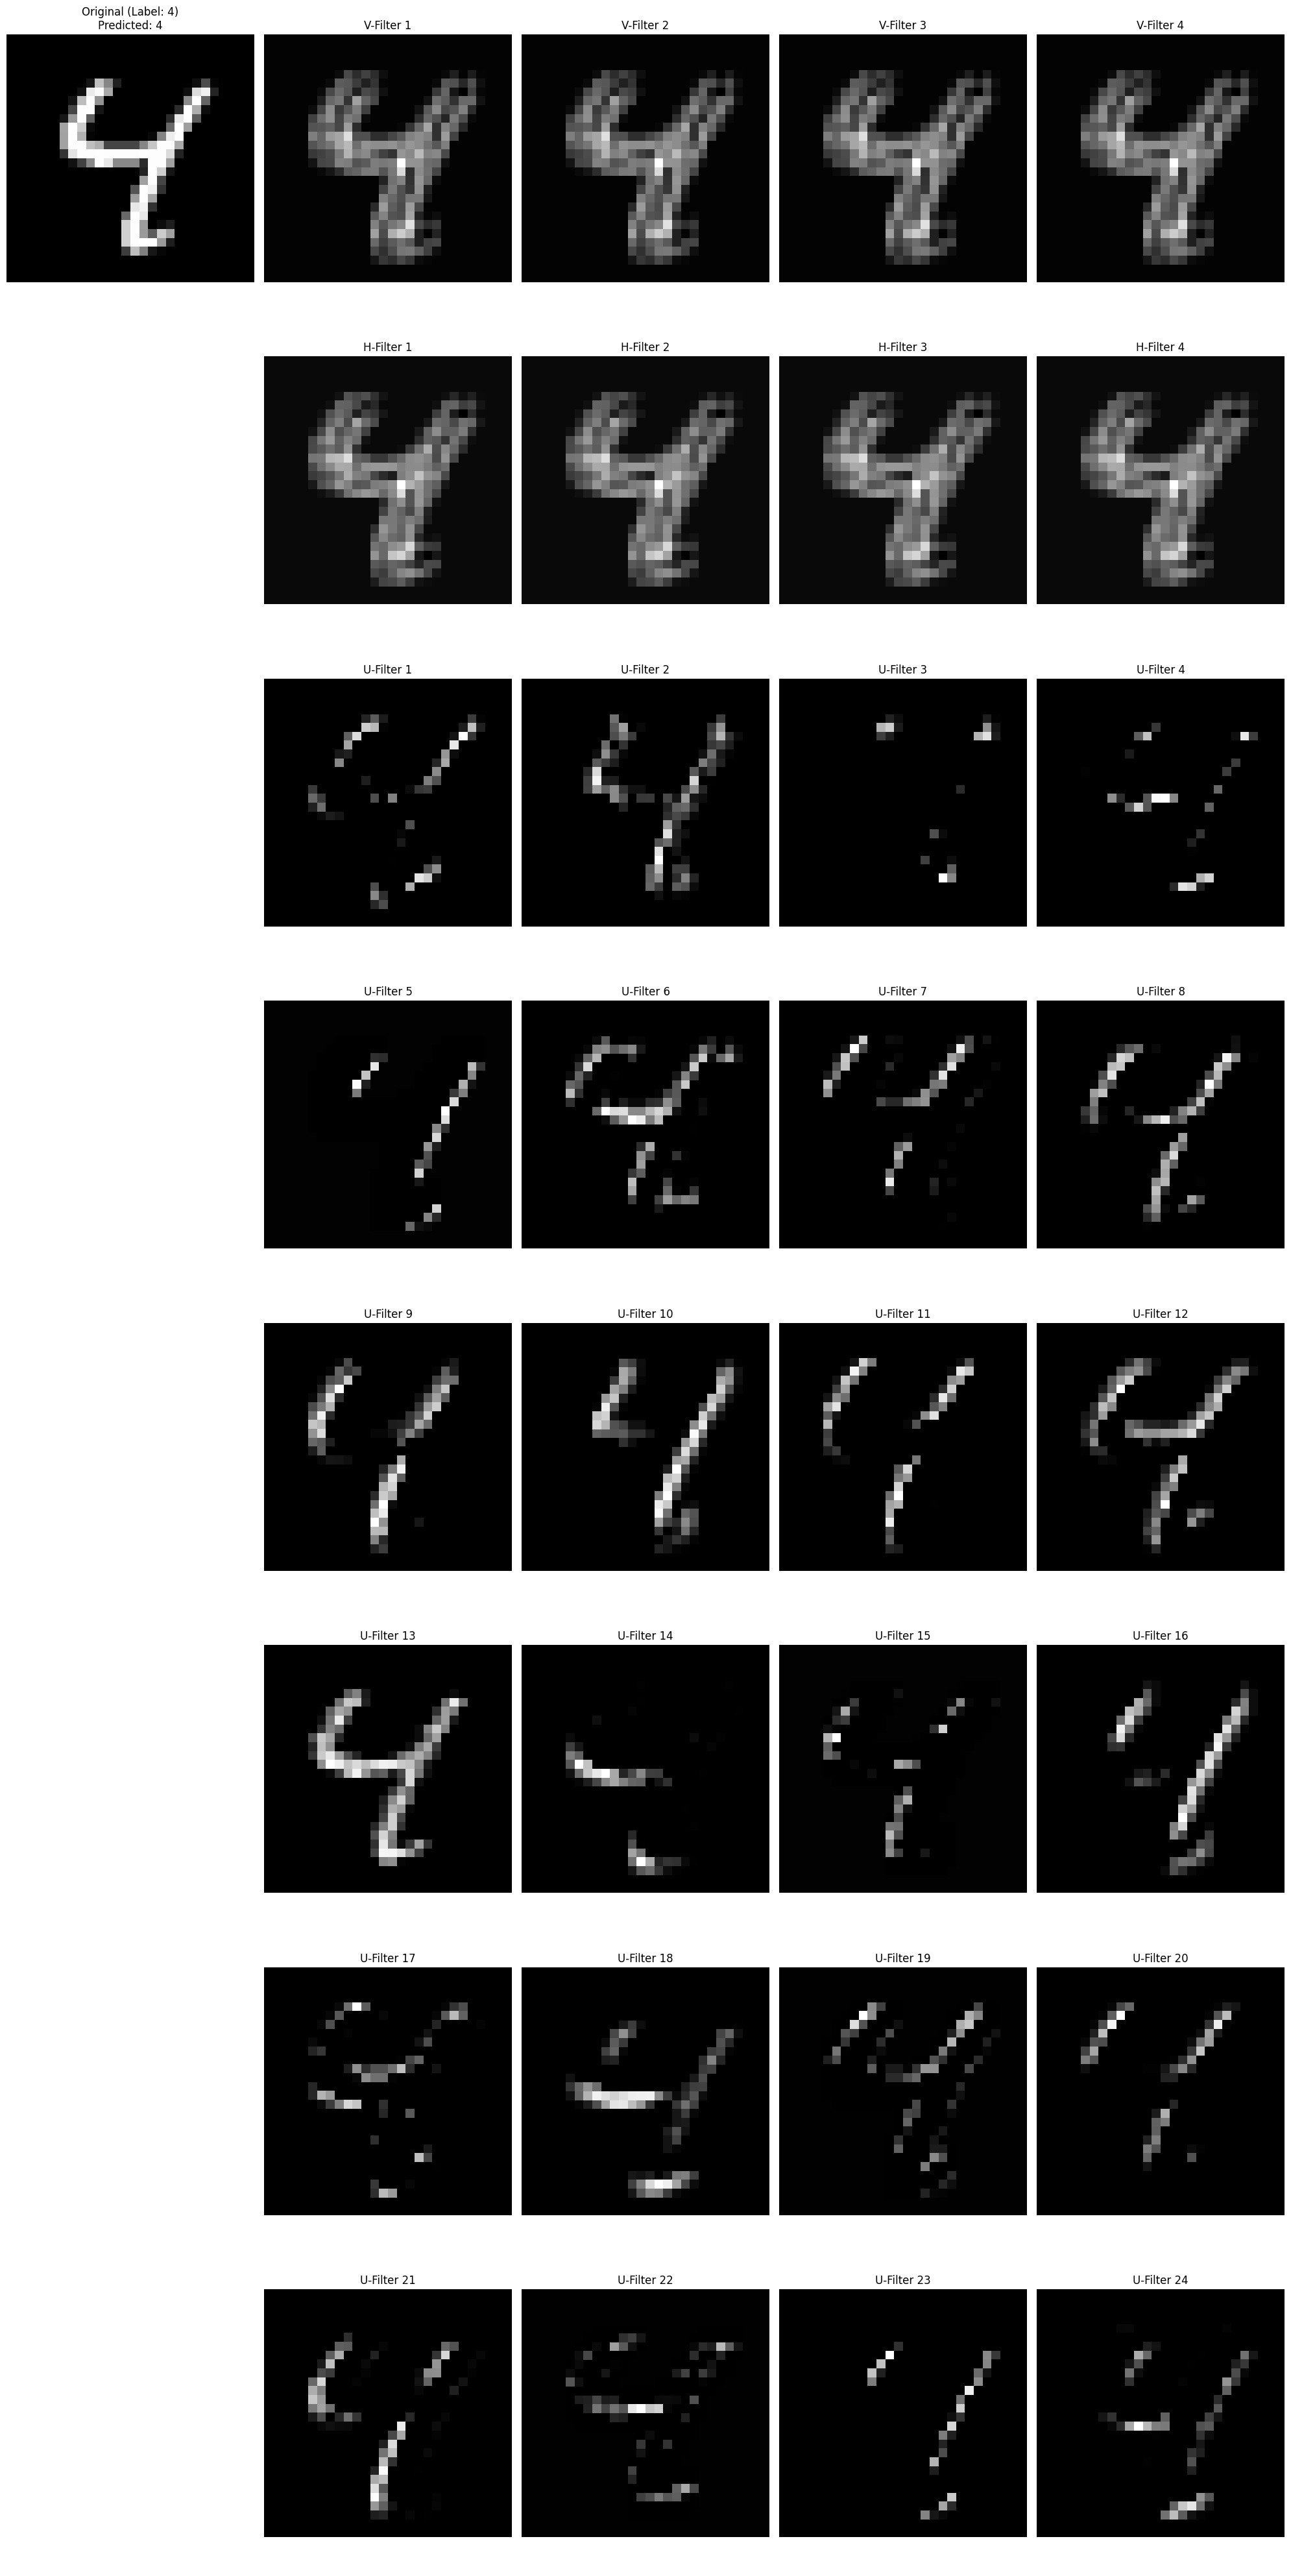

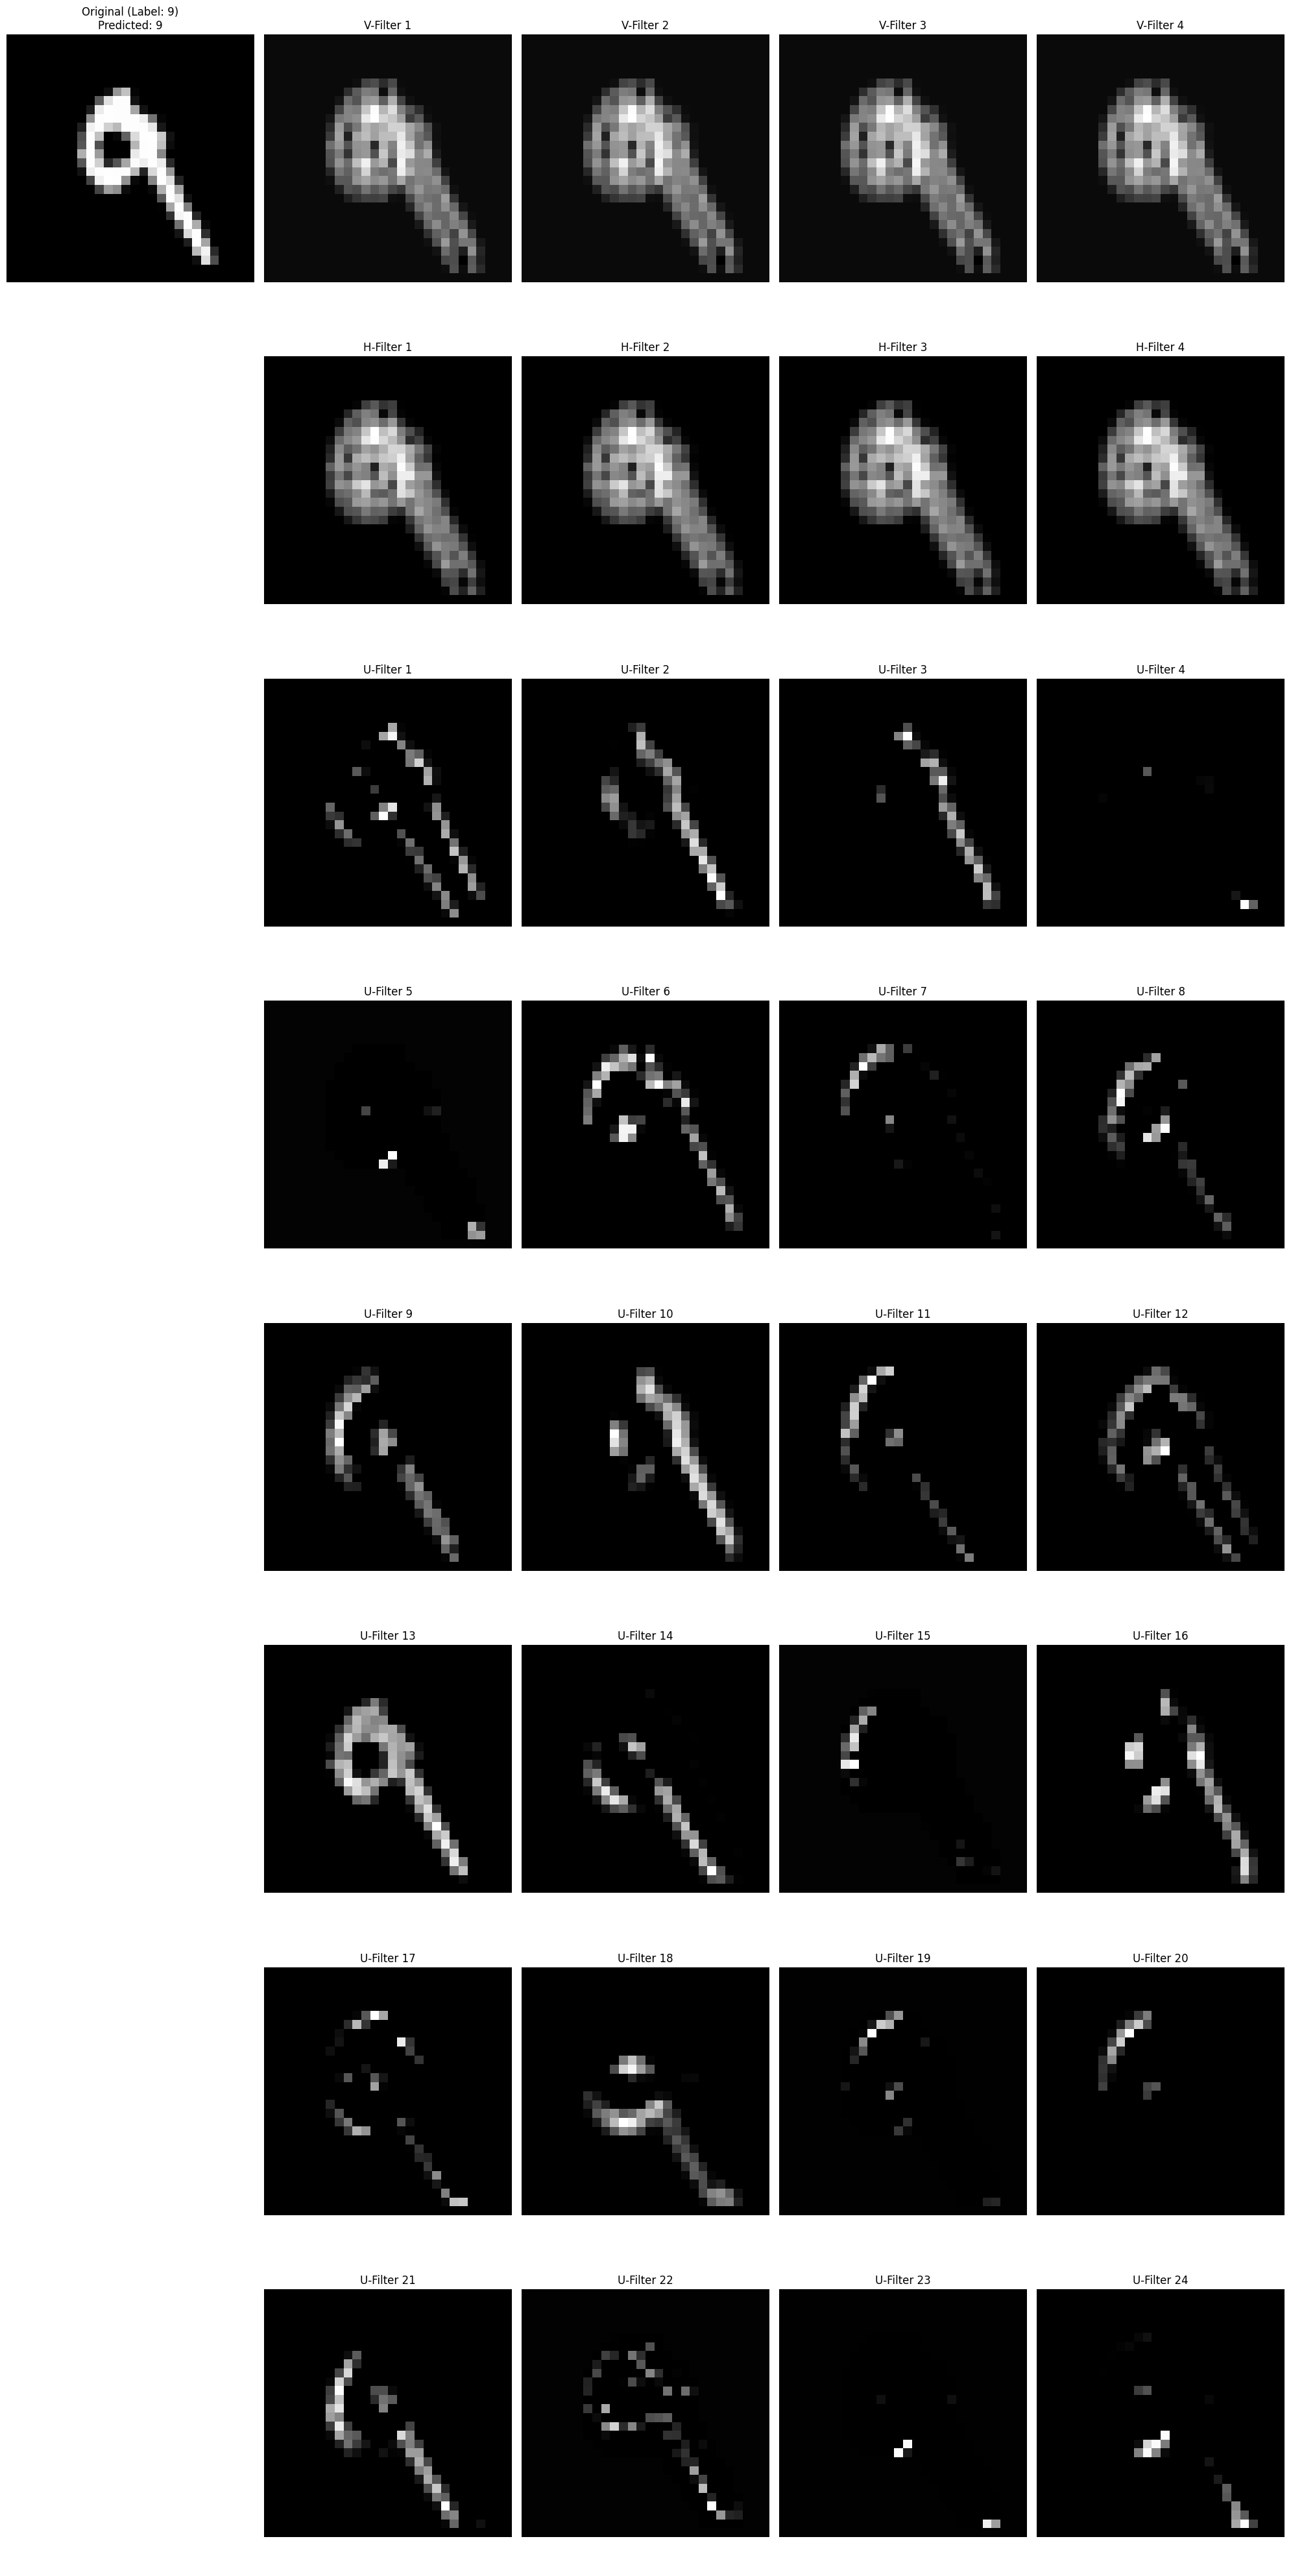

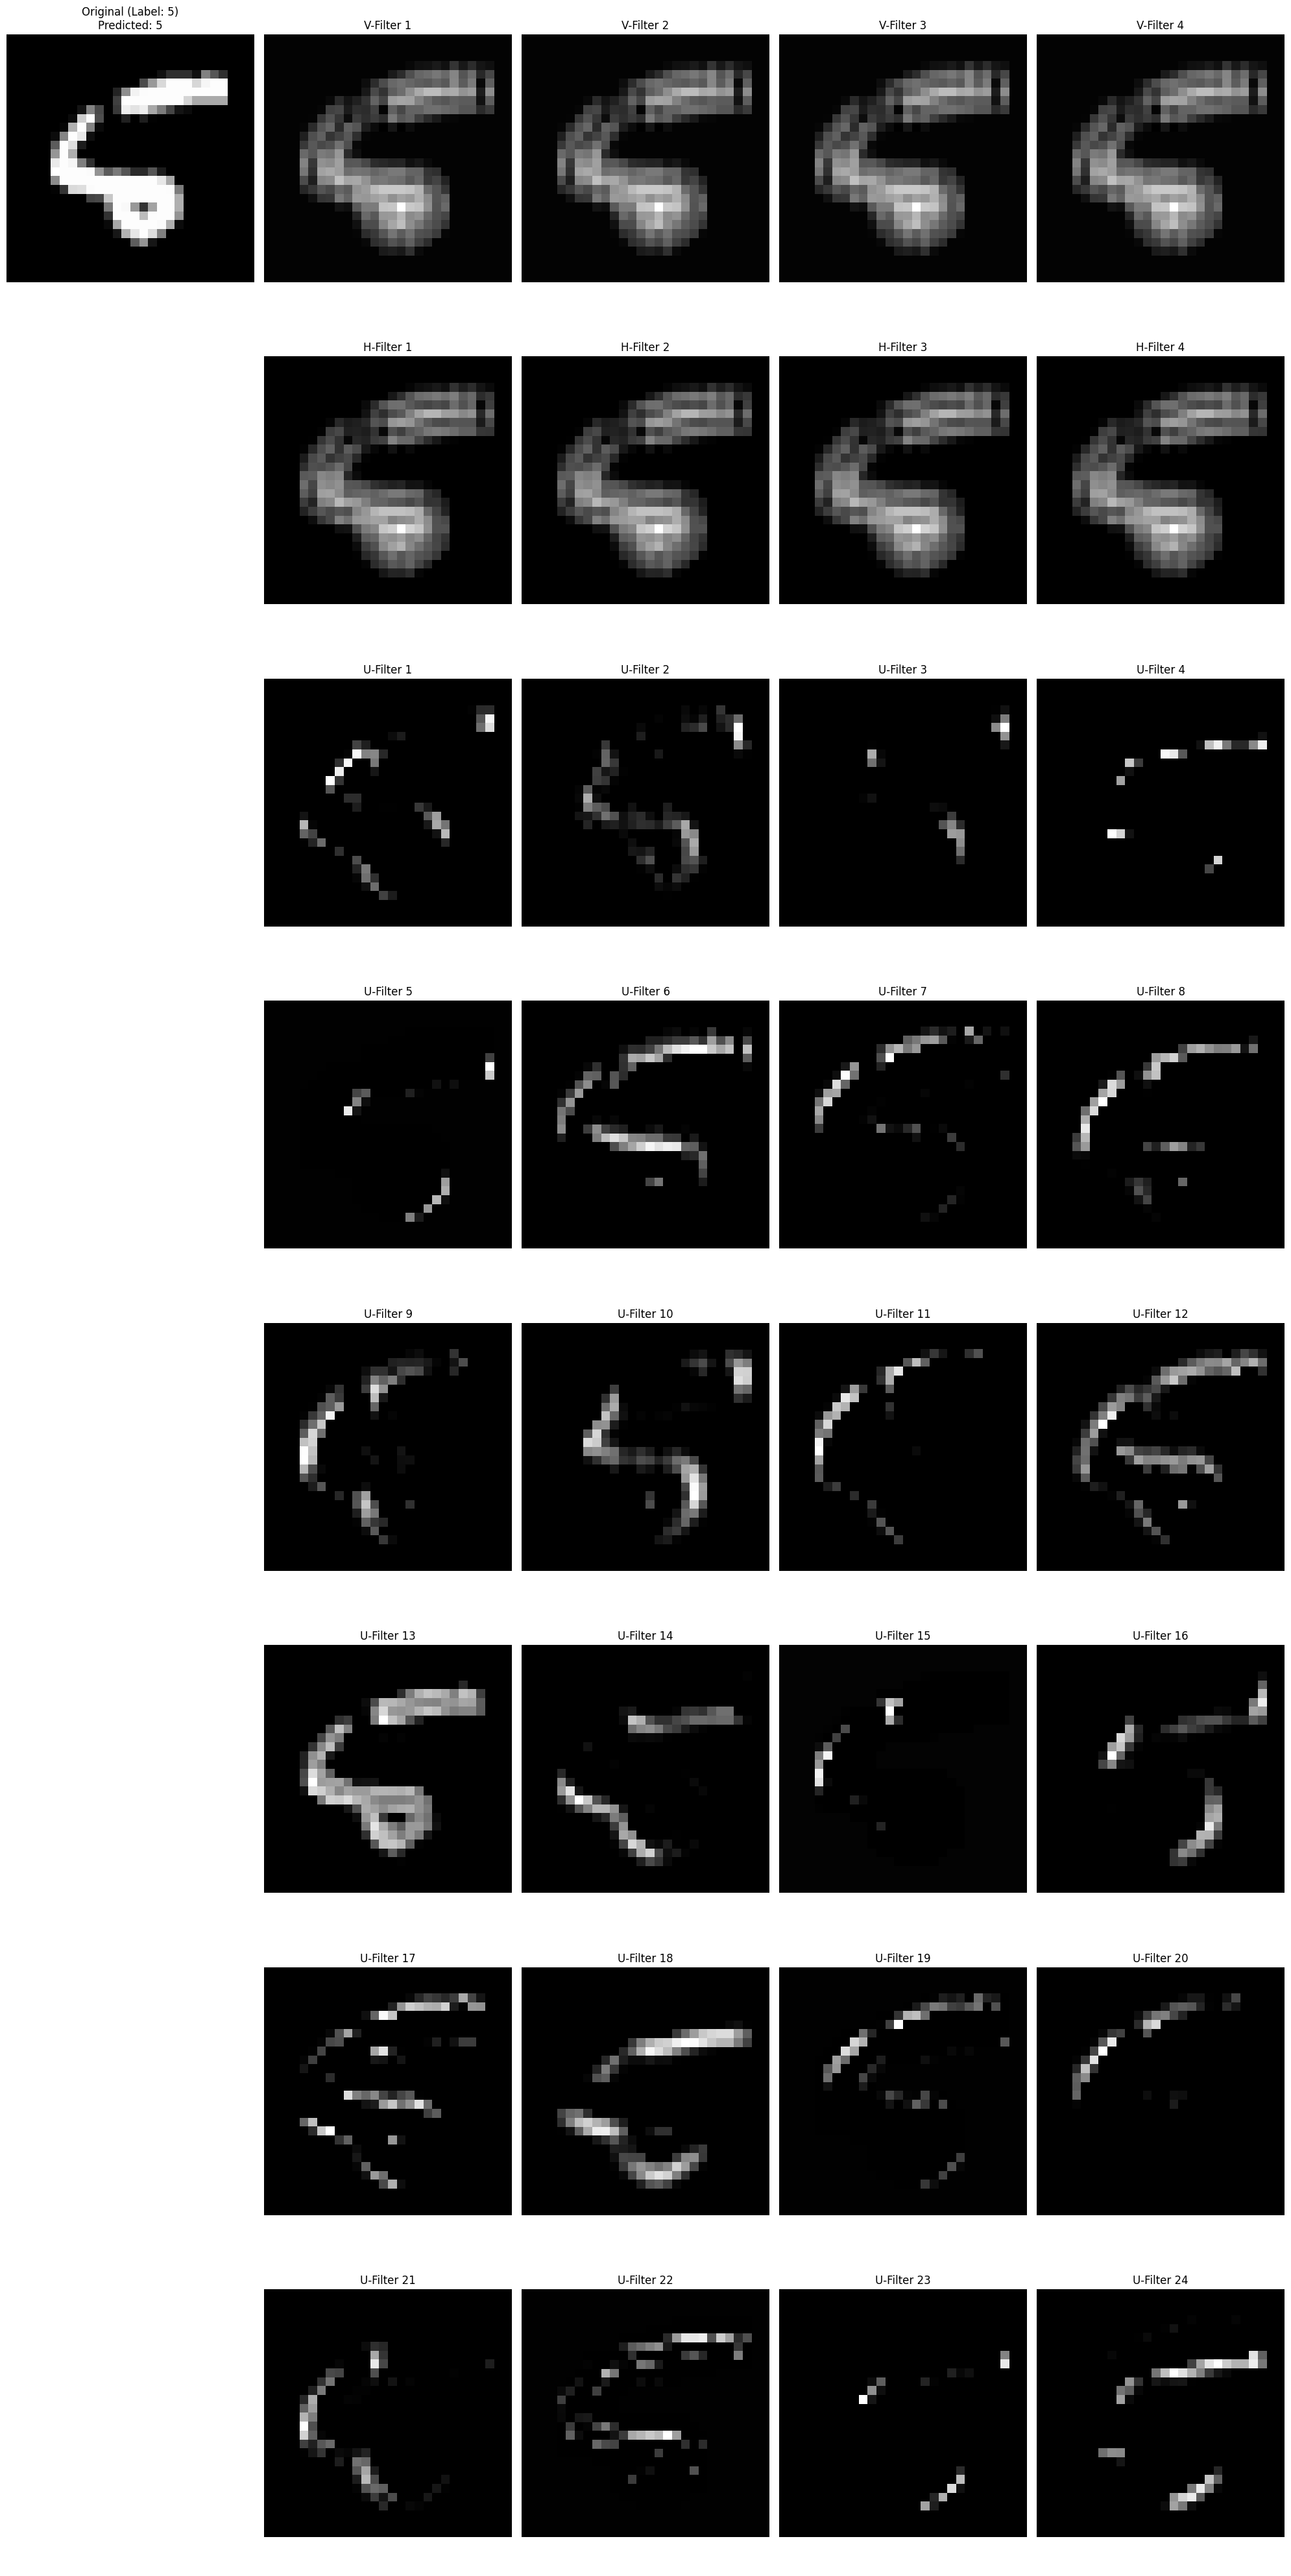

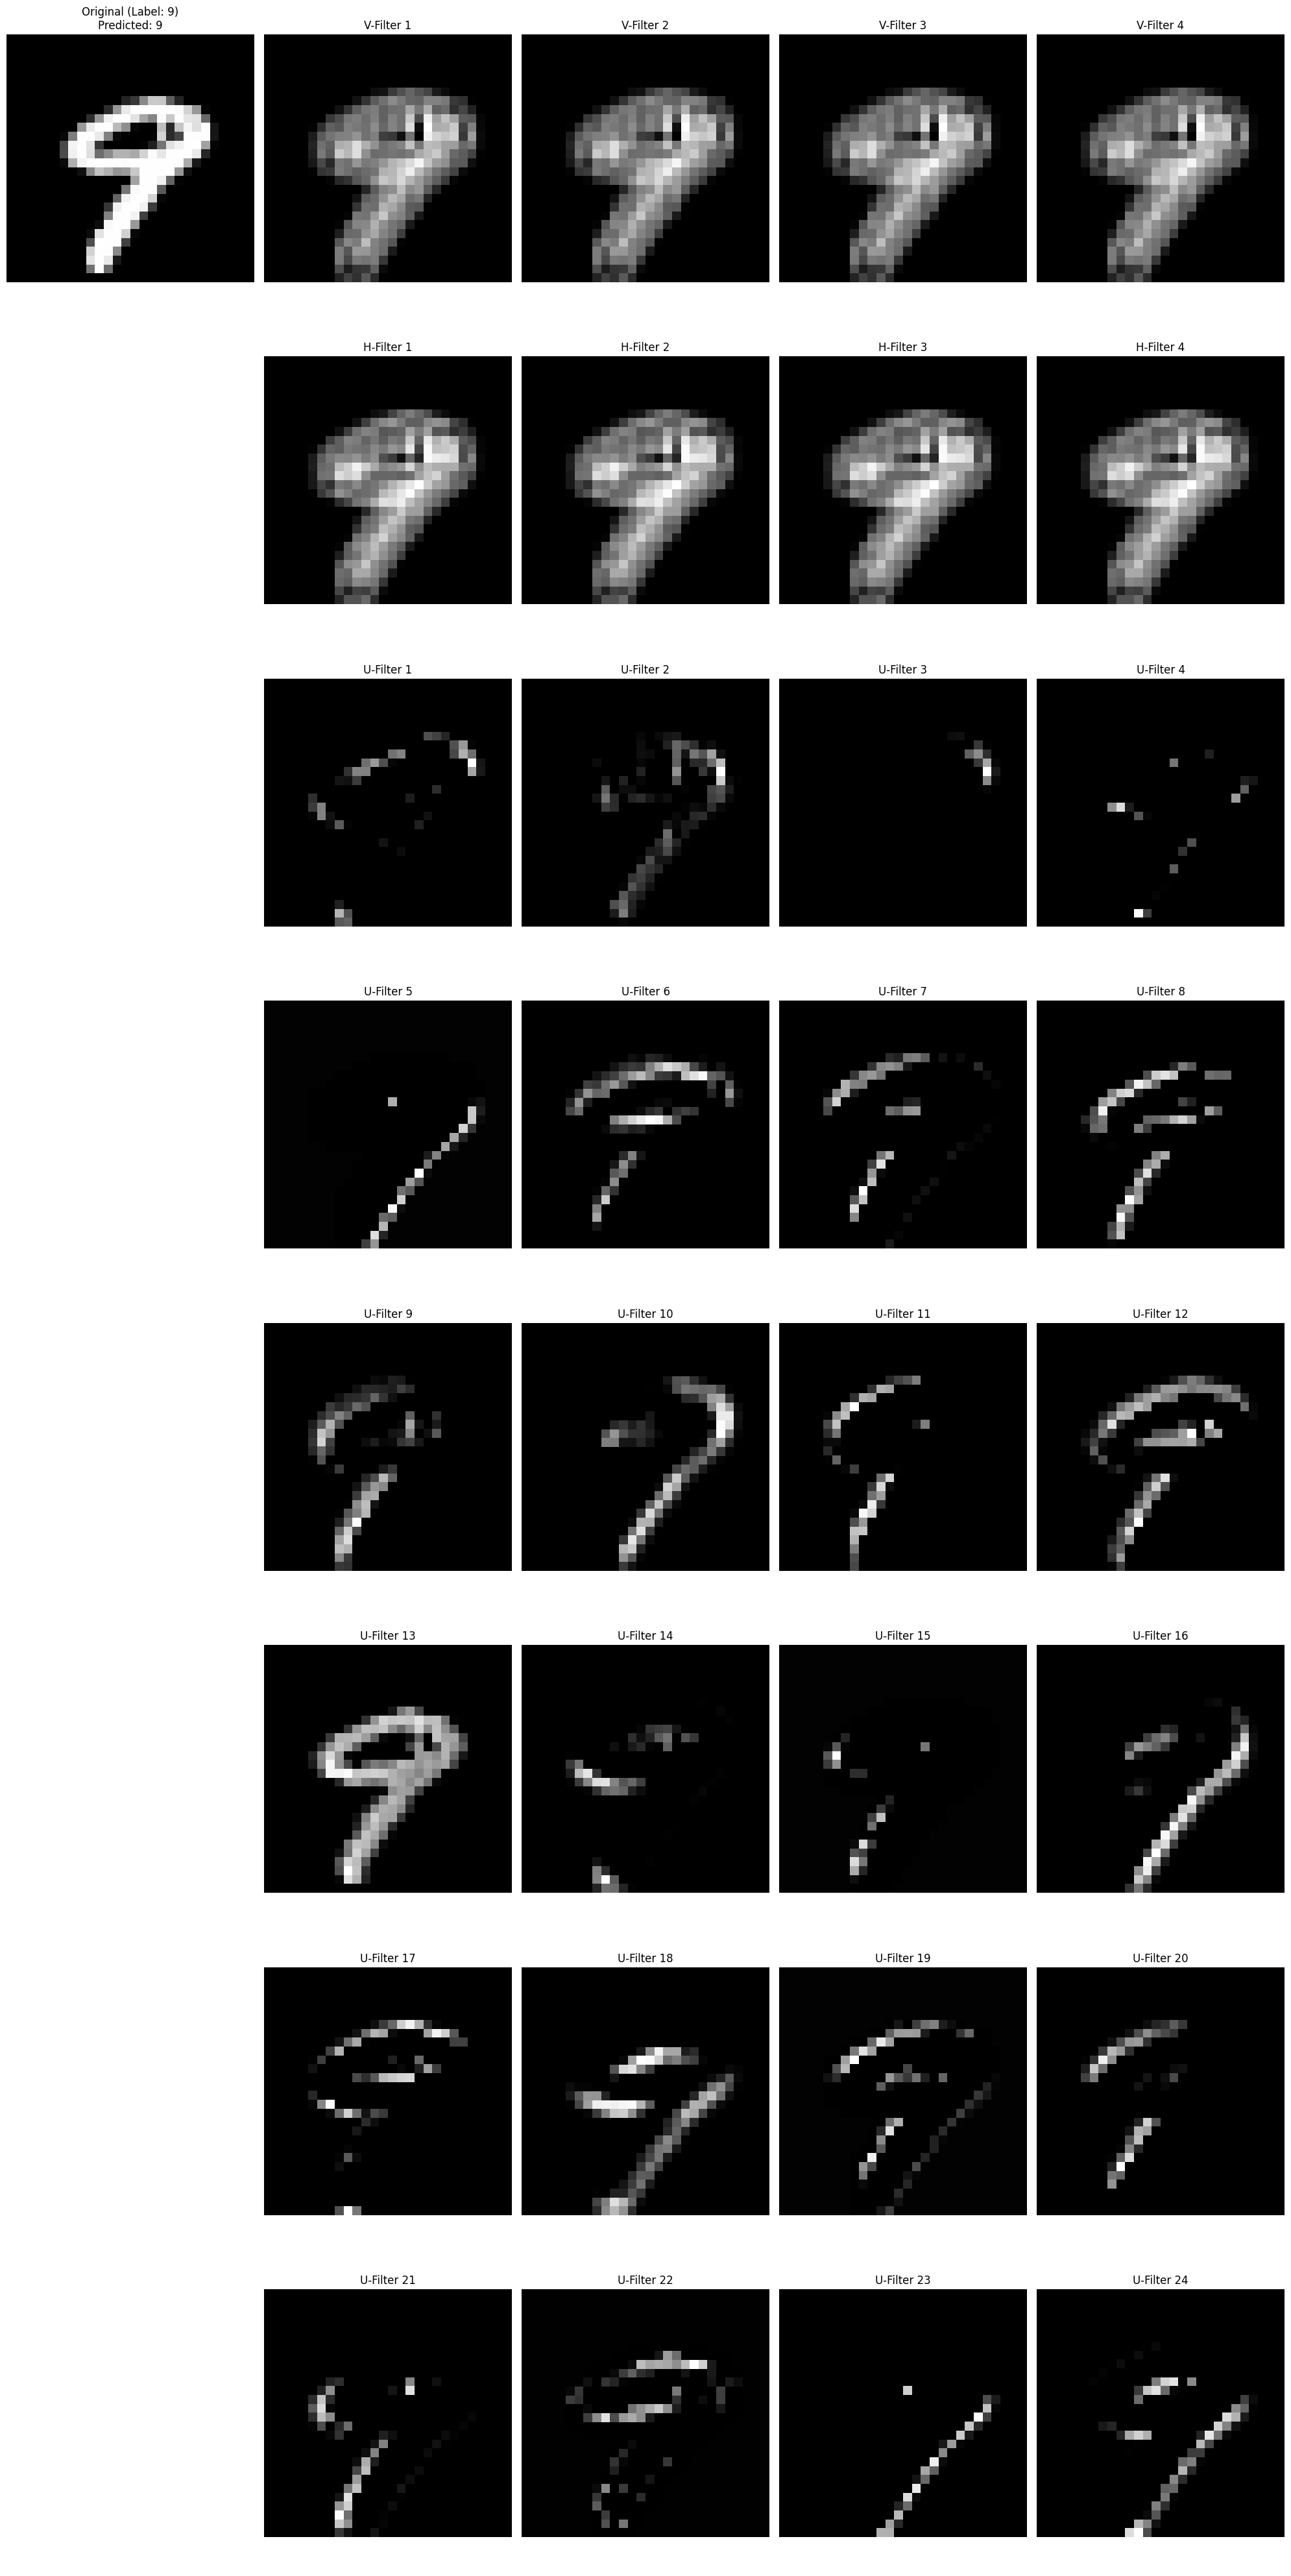

In [39]:
for example in eval_examples[:10]:
    label, img, out, v_act_imgs, h_act_imgs, other_act_imgs = example
    visualize_kernel_activations(img, label, v_act_imgs, h_act_imgs, other_act_imgs[8:], out)